# 2D HDF Data Extraction

## OverviewThis notebook demonstrates extracting and analyzing **2D mesh results** from HEC-RAS HDF5 files. 2D modeling represents overland flow using a computational mesh rather than 1D cross sections.**2D vs 1D Modeling**:- **1D**: Flow confined to channel, cross sections perpendicular to flow- **2D**: Flow in two horizontal dimensions, mesh cells represent floodplain- **Combined 1D/2D**: Hybrid approach (channel in 1D, floodplain in 2D)### HDF5 Structure for 2D Results```/Results/Unsteady/Output/├── Output Blocks/│   └── Base Output/│       ├── Unsteady Time Series/│       │   ├── 2D Flow Areas/│       │   │   ├── {Area Name}/│       │   │   │   ├── Depth/           # Water depth at cell centers│       │   │   │   ├── Water Surface/   # WSE at cell centers│       │   │   │   ├── Velocity/        # Velocity magnitude│       │   │   │   ├── Face Velocity/   # Velocity at cell faces│       │   │   │   └── Shear Stress/    # Bed shear stress│       └── Summary Output/│           └── 2D Flow Areas/│               └── {Area Name}/│                   ├── Maximum/         # Maximum values over simulation│                   └── Minimum/```**Key 2D Datasets**:- **Mesh Geometry**: `/Geometry/2D Flow Areas/{Area}/Cells Center Coordinate`- **Cell Depth**: Water depth at each mesh cell (ft or m)- **Cell WSE**: Water surface elevation (ft or m above datum)- **Velocity**: Velocity magnitude and direction at cell centers- **Face Data**: Velocity and flow at cell faces (see 412 notebook)### Reference Documentation- [HEC-RAS 2D Modeling User's Manual](https://www.hec.usace.army.mil/software/hec-ras/documentation.aspx) - Complete 2D reference- [HEC-RAS User's Manual, Chapter 9: Viewing Results](https://www.hec.usace.army.mil/software/hec-ras/documentation.aspx)- [HEC-RAS 2D Theory](https://www.hec.usace.army.mil/software/hec-ras/documentation.aspx) - Shallow water equations, numerical methods### LLM Forward Engineering: 2D Model Verification2D model results require additional verification due to mesh-based computation:1. **Mass Balance**: Verify inflow = outflow + storage change2. **Mesh Resolution**: Ensure cell size adequate for features of interest3. **Courant Number**: Check for numerical stability (Courant < 1 typically)4. **Wet/Dry Tracking**: Verify wetting/drying front behaves physically

In [1]:
# =============================================================================
# DEVELOPMENT MODE TOGGLE
# =============================================================================
USE_LOCAL_SOURCE = True  # <-- TOGGLE THIS

if USE_LOCAL_SOURCE:
    import sys
    from pathlib import Path
    local_path = str(Path.cwd().parent)
    if local_path not in sys.path:
        sys.path.insert(0, local_path)
    print(f"📁 LOCAL SOURCE MODE: Loading from {local_path}/ras_commander")
else:
    print("📦 PIP PACKAGE MODE: Loading installed ras-commander")

# Import ras-commander
from ras_commander import HdfBase, HdfBndry, HdfMesh, HdfPlan, HdfResultsMesh, HdfResultsPlan, HdfStruc, HdfUtils, RasCmdr, RasExamples, init_ras_project, ras

# Additional imports for this notebook
import h5py
import numpy as np
import pandas as pd
import requests
from tqdm import tqdm
import scipy
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython import display
import psutil  # For getting system CPU info
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
import subprocess
import os
import shutil
from datetime import datetime, timedelta
from pathlib import Path  # Ensure pathlib is imported for file operations
import rasterio
from rasterio.plot import show
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
import logging

# Verify which version loaded
import ras_commander
print(f"✓ Loaded: {ras_commander.__file__}")

📦 PIP PACKAGE MODE: Loading installed ras-commander


✓ Loaded: c:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\ras_commander\__init__.py


## Parameters

Configure these values to customize the notebook for your project.

In [ ]:
# =============================================================================
# PARAMETERS - Edit these to customize the notebook
# =============================================================================
from pathlib import Path

# Project Configuration
PROJECT_NAME = "Muncie"           # Example project to extract
RAS_VERSION = "6.6"               # HEC-RAS version (6.3, 6.5, 6.6, etc.)

# HDF Analysis Settings
PLAN = "01"                       # Plan number (for HDF file path)
TIME_INDEX = -1                   # Time step index (-1 = last)
PROFILE = "Max"                   # Profile name for steady analysis


# HEC-RAS 2D HDF Data Analysis Notebook

This notebook demonstrates how to manipulate and analyze HEC-RAS 2D HDF data using the ras-commander library. It leverages the HdfBase, HdfUtils, HdfStruc, HdfMesh, HdfXsec, HdfBndry, HdfPlan, HdfResultsPlan, HdfResultsMesh, and HdfResultsXsec classes to streamline data extraction, processing, and visualization.


In [2]:
# Install ras-commander from pip (uncomment to install if needed)
#!pip install ras-commander
# This installs ras-commander and all dependencies

# Use this setting to disable plot generation within the notebook
generate_plots = True
# Use this setting to disable map generation within the notebook
generate_maps = True
# Set both to false for llm-friendly outputs

# Use Example Project or Load Your Own Project

In [3]:
# Extract the BaldEagleCrkMulti2D example project using static method
the_path = RasExamples.extract_project(PROJECT_NAME, suffix="11")
print(f"Extracted project to: {the_path}")

# Verify the path exists
print(f"BaldEagleCrkMulti2D project exists: {the_path.exists()}")

# Initialize the RAS project using the default global ras object
import logging
init_ras_project(the_path, RAS_VERSION)
logging.info(f"Balde Eagle Mult 2D project initialized with folder: {ras.project_folder}")

# Execute Plan 06 (2D)
RasCmdr.compute_plan("06", skip_existing=True, num_cores=2)

# Define plan_number for use in subsequent cells
plan_number = "06"
print(f"Plan number set to: {plan_number}")

2025-12-16 20:58:23 - ras_commander.RasExamples - INFO - Found zip file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\Example_Projects_6_6.zip


2025-12-16 20:58:23 - ras_commander.RasExamples - INFO - Loading project data from CSV...


2025-12-16 20:58:23 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.


2025-12-16 20:58:23 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----


2025-12-16 20:58:23 - ras_commander.RasExamples - INFO - Extracting project 'BaldEagleCrkMulti2D' as 'BaldEagleCrkMulti2D_11'


2025-12-16 20:58:24 - ras_commander.RasExamples - INFO - Successfully extracted project 'BaldEagleCrkMulti2D' to C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11


2025-12-16 20:58:24 - ras_commander.rasmap - INFO - Successfully parsed RASMapper file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.rasmap


2025-12-16 20:58:24 - root - INFO - Balde Eagle Mult 2D project initialized with folder: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11


2025-12-16 20:58:24 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11


2025-12-16 20:58:24 - ras_commander.RasUtils - INFO - Using provided plan file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06


2025-12-16 20:58:24 - ras_commander.RasUtils - INFO - Successfully updated file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06


2025-12-16 20:58:25 - ras_commander.RasCmdr - INFO - Set number of cores to 2 for plan: 06


2025-12-16 20:58:25 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:


2025-12-16 20:58:25 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.prj" "C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06"


Extracted project to: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11
BaldEagleCrkMulti2D project exists: True


2025-12-16 21:03:21 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 06


2025-12-16 21:03:21 - ras_commander.RasCmdr - INFO - Total run time for plan 06: 296.67 seconds


Plan number set to: 06


## Extracting 2D Computation Messages

For 2D models, computation messages are especially important for understanding:
- 2D mesh stability and timestep information
- Wet/dry cell transitions
- Volume accounting and mass balance
- Performance metrics for large 2D meshes

In [4]:
# Extract computation messages for 2D analysis
from ras_commander import HdfResultsPlan

print("="*80)
print("2D MODEL COMPUTATION MESSAGES")
print("="*80)

msgs_2d = HdfResultsPlan.get_compute_messages(plan_number)

if msgs_2d:
    print(f"\nExtracted {len(msgs_2d)} characters of computation messages\n")
    
    # Display first portion
    print("Computation messages (first 1000 characters):")
    print("-" * 80)
    print(msgs_2d[:1000])
    
    if len(msgs_2d) > 1000:
        print("\n... (truncated for display) ...")
    
    # Check for 2D-specific information
    print("\n" + "="*80)
    print("Looking for 2D-specific information...")
    print("="*80)
    
    lines = msgs_2d.split('\n')
    keywords = ['2d', 'mesh', 'timestep', 'volume', 'courant']
    relevant = [l for l in lines if any(kw in l.lower() for kw in keywords)]
    
    if relevant:
        print(f"Found {len(relevant)} lines with 2D-related information:")
        for line in relevant[:10]:
            print(f"  - {line.strip()}")
    else:
        print("No specific 2D keywords found in messages")
else:
    print("No computation messages available for this 2D plan")

print("\n" + "="*80)

2025-12-16 21:03:21 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:21 - ras_commander.hdf.HdfResultsPlan - INFO - Reading computation messages from HDF: BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:21 - ras_commander.hdf.HdfResultsPlan - INFO - Successfully extracted 1695 characters from HDF


2D MODEL COMPUTATION MESSAGES

Extracted 1695 characters of computation messages

Computation messages (first 1000 characters):
--------------------------------------------------------------------------------
Plan: 'Gridded Precip - Infiltration' (BaldEagleDamBrk.p06)
Simulation started at: 16Dec2025 08:58:27 PM

Writing Plan GIS Data...
Completed Writing Plan GIS Data
Writing Geometry...
Computing 2D Flow Area 'BaldEagleCr' tables: Property tables do not exist.
2D Flow Area 'BaldEagleCr' tables complete 9.11 sec
Completed Writing Geometry
Writing Event Conditions ...
 
Processing Precipitation data...
   (assumes geometry data is geo-referenced)
Finished Processing Precipitation data (1.558s)
Completed Writing Event Condition Data

	
Geometric Preprocessor HEC-RAS 6.6 September 2024
 

Finished Processing Geometry


Performing Unsteady Flow Simulation  HEC-RAS 6.6 September 2024
 
	
Unsteady Input Summary:
     2D Unsteady Diffusion Wave Equation Set (fastest)
     2D number of Solver

###  OPTIONAL: Use your own project instead

your_project_path = Path(r"D:\yourprojectpath")

init_ras_project(your_project_path, "6.6")
plan_number = "01"  # Plan number to use for this notebook 



### If you use this code cell, don't run the previous cell or change to markdown
### NOTE: Ensure the HDF Results file was generated by HEC-RAS Version 6.x or above

-----

# Explore Project Dataframes using 'ras' Object

In [5]:
# Show ras object info
ras.plan_df

,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,...,DSS File,Friction Slope Method,UNET D2 SolverType,UNET D2 Name,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path
0,13,07,06,PMF with Multi 2D Areas,5.10,PMF Multi 2D,"01JAN1999,1200,04JAN1999,1200",30SEC,30MIN,1,...,dss,1,Pardiso (Direct),193,None,06,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,07,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
1,15,12,08,1d-2D Dambreak Refined Grid,5.10,1D-2D Refined Grid,"01JAN1999,1200,04JAN1999,1200",20SEC,5MIN,1,...,dss,1,NaN,BaldEagleCr,None,08,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,12,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
2,17,09,10,2D to 1D No Dam,5.00,2D to 1D No Dam,"01JAN1999,1200,06JAN1999,1200",1MIN,5MIN,1,...,dss,1,NaN,Upstream2D,None,10,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,09,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
3,18,10,11,2D to 2D Run,5.00,2D to 2D Run,"01JAN1999,1200,04JAN1999,1200",20SEC,5MIN,1,...,dss,1,NaN,BaldEagleCr,None,11,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,10,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
4,19,11,12,SA to 2D Dam Break Run,5.00,SA to 2D Dam Break,"01JAN1999,1200,04JAN1999,1200",20SEC,10MIN,1,...,dss,1,NaN,BaldEagleCr,None,12,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,11,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
5,03,13,09,Single 2D Area - Internal Dam Structure,5.04,Single 2D,"01JAN1999,1200,04JAN1999,1200",30SEC,10MIN,1,...,dss,1,NaN,BaldEagleCr,None,09,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,13,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
6,04,01,13,SA to 2D Area Conn - 2D Levee Structure,5.00,2D Levee Struc,"01JAN1999,1200,04JAN1999,1200",20SEC,5MIN,1,...,dss,1,NaN,BaldEagleCr,None,13,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
7,02,01,01,SA to Detailed 2D Breach,5.10,SA-2D Det Brch,"01JAN1999,1200,04JAN1999,1200",10SEC,5MIN,1,...,dss,1,Pardiso (Direct),BaldEagleCr,None,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
8,01,01,01,SA to Detailed 2D Breach FEQ,5.03,SA-2D Det FEQ,"01JAN1999,1200,04JAN1999,1200",5SEC,5MIN,1,...,dss,1,NaN,BaldEagleCr,None,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
9,05,02,03,Single 2D area with Bridges FEQ,5.10,Single 2D Bridges FEQ,"01JAN1999,1200,04JAN1999,1200",5SEC,10MIN,-1,...,dss,1,PARDISO (Direct),BaldEagleCr,None,03,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,02,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...


In [6]:
ras.unsteady_df

,unsteady_number,full_path,Flow Title,Program Version,Use Restart,Precipitation Mode,Wind Mode,Met BC=Precipitation|Mode,Met BC=Evapotranspiration|Mode,Met BC=Precipitation|Expanded View,Met BC=Precipitation|Constant Units,Met BC=Precipitation|Gridded Source
0,07,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,PMF with Multi 2D Areas,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,08,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,PMF for Upstream 2D,4.20,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,09,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,Upstream 2D,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,1972 Flood Event - 2D to 2D Run,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,1972 Flood Event - SA to 2D Run,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,12,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,PMF for 1D - 2D,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,13,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,Single 2D Area,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,1972 Flood Event - 2D Leve Structure,5.10,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,02,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,Single 2D Area with Bridges,5.10,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,03,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,Gridded Precipitation,6.00,0,Enable,No Wind Forces,Gridded,None,-1,mm/hr,DSS


In [7]:
ras.boundaries_df 

,unsteady_number,boundary_condition_number,river_reach_name,river_station,storage_area_name,pump_station_name,bc_type,hydrograph_type,Interval,DSS File,...,Flow Title,Program Version,Use Restart,Precipitation Mode,Wind Mode,Met BC=Precipitation|Mode,Met BC=Evapotranspiration|Mode,Met BC=Precipitation|Expanded View,Met BC=Precipitation|Constant Units,Met BC=Precipitation|Gridded Source
0,07,1,Bald Eagle Cr.,Lock Haven,137520,,Flow Hydrograph,Flow Hydrograph,1HOUR,Bald_Eagle_Creek.dss,...,PMF with Multi 2D Areas,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,07,2,Bald Eagle Cr.,Lock Haven,81454,,Gate Opening,None,NaN,NaN,...,PMF with Multi 2D Areas,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,07,3,Bald Eagle Cr.,Lock Haven,28519,,Lateral Inflow Hydrograph,Lateral Inflow Hydrograph,1HOUR,Bald_Eagle_Creek.dss,...,PMF with Multi 2D Areas,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,07,4,Bald Eagle Cr.,Lock Haven,1,,Lateral Inflow Hydrograph,Lateral Inflow Hydrograph,1HOUR,NaN,...,PMF with Multi 2D Areas,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,07,5,Bald Eagle Cr.,Lock Haven,136948,82303,Uniform Lateral Inflow Hydrograph,Uniform Lateral Inflow Hydrograph,1HOUR,Bald_Eagle_Creek.dss,...,PMF with Multi 2D Areas,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,07,6,Bald Eagle Cr.,Lock Haven,80720,67130,Uniform Lateral Inflow Hydrograph,Uniform Lateral Inflow Hydrograph,1HOUR,Bald_Eagle_Creek.dss,...,PMF with Multi 2D Areas,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,07,7,Bald Eagle Cr.,Lock Haven,76865,,Lateral Inflow Hydrograph,Lateral Inflow Hydrograph,1HOUR,Bald_Eagle_Creek.dss,...,PMF with Multi 2D Areas,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,07,8,Bald Eagle Cr.,Lock Haven,67130,,Lateral Inflow Hydrograph,Lateral Inflow Hydrograph,1HOUR,Bald_Eagle_Creek.dss,...,PMF with Multi 2D Areas,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,07,9,Bald Eagle Cr.,Lock Haven,66041,1,Uniform Lateral Inflow Hydrograph,Uniform Lateral Inflow Hydrograph,1HOUR,Bald_Eagle_Creek.dss,...,PMF with Multi 2D Areas,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,07,10,Bald Eagle Cr.,Lock Haven,-1867,,Normal Depth,None,NaN,NaN,...,PMF with Multi 2D Areas,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
ras.get_hdf_entries()

,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,...,DSS File,Friction Slope Method,UNET D2 SolverType,UNET D2 Name,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path
10,06,03,09,Gridded Precip - Infiltration,6.00,Grid Precip Infiltration,"09SEP2018,0000,14SEP2018,0000",20SEC,10MIN,-1,...,dss,1,Pardiso (Direct),BaldEagleCr,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,09,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,03,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...


# Find Paths for Results and Geometry HDF's

In [9]:
# Get the plan HDF path for the plan_number defined above
plan_hdf_path = ras.plan_df.loc[ras.plan_df['plan_number'] == plan_number, 'HDF_Results_Path'].values[0]

In [10]:
plan_hdf_path

'C:\\Users\\billk_clb\\anaconda3\\envs\\rascmdr_piptest\\Lib\\site-packages\\examples\\example_projects\\BaldEagleCrkMulti2D_11\\BaldEagleDamBrk.p06.hdf'

In [11]:
# Alternate: Get the geometry HDF path if you are extracting geometry elements from the geometry HDF
geom_hdf_path = ras.plan_df.loc[ras.plan_df['plan_number'] == plan_number, 'Geom Path'].values[0] + '.hdf'

In [12]:
geom_hdf_path

'C:\\Users\\billk_clb\\anaconda3\\envs\\rascmdr_piptest\\Lib\\site-packages\\examples\\example_projects\\BaldEagleCrkMulti2D_11\\BaldEagleDamBrk.g09.hdf'

## RAS-Commander's Decorators Allow for Flexible Function Calling
You can call most of the functions in the HDF* Classes using any of the following:
1. Plan/Geometry Number (with or without leading zeros):
   - "01", "1" - Plan/geometry number as string
   - 1 - Plan/geometry number as integer
   - "p01", "p1" - Plan number with 'p' prefix
2. Direct File Paths:
   - pathlib.Path object pointing to HDF file
   - String path to HDF file

3. h5py.File Objects:
   - Already opened HDF file object

The @standardize_input decorator handles all these input types consistently:
   - Validates the input exists and is accessible
   - Converts to proper pathlib.Path object
   - Handles RAS object references
   - Provides logging and error handling

This flexibility makes it easier to work with HDF files in different contexts while maintaining consistent behavior 
across the codebase, and helps prevent strict typing from introducing unnecessary friction for LLM Coding.


-----

# 2D HDF Data Extraction Examples

In [13]:
# Extract runtime and compute time data as dataframe
print("\nExtracting runtime and compute time data")
runtime_df = HdfResultsPlan.get_runtime_data(hdf_path=plan_number)

2025-12-16 21:03:21 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:21 - ras_commander.hdf.HdfResultsPlan - INFO - Extracting Plan Information from: BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:21 - ras_commander.hdf.HdfResultsPlan - INFO - Plan Name: Gridded Precip - Infiltration


2025-12-16 21:03:21 - ras_commander.hdf.HdfResultsPlan - INFO - Simulation Duration (hours): 120.0



Extracting runtime and compute time data


In [14]:
runtime_df

,Plan Name,File Name,Simulation Start Time,Simulation End Time,Simulation Duration (s),Simulation Time (hr),Completing Geometry (hr),Preprocessing Geometry (hr),Completing Event Conditions (hr),Unsteady Flow Computations (hr),Complete Process (hr),Unsteady Flow Speed (hr/hr),Complete Process Speed (hr/hr)
0,Gridded Precip - Infiltration,BaldEagleDamBrk.p06.hdf,2018-09-09,2018-09-14,432000.0,120.0,N/A,0.000022,N/A,0.077778,0.081497,1542.857143,1472.442824


In [15]:
# For all of the RasGeomHdf Class Functions, we will use geom_hdf_path
print(geom_hdf_path)

# For the example project, plan 06 is associated with geometry 09
# If you want to call the geometry by number, call RasHdfGeom functions with a number
# Otherwise, if you want to look up geometry hdf path by plan number, follow the logic in the previous code cells

C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


In [16]:
# Use HdfUtils for extracting projection
print("\nExtracting Projection from HDF")
projection = HdfBase.get_projection(hdf_path=geom_hdf_path)


2025-12-16 21:03:21 - ras_commander.hdf.HdfBase - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:21 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:21 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:21 - ras_commander.hdf.HdfBase - INFO - Converted WKT to EPSG:2271 from HDF file BaldEagleDamBrk.g09.hdf



Extracting Projection from HDF


In [17]:
projection

'EPSG:2271'

In [18]:
# Use HdfPlan for geometry-related operations
print("\nExtracting Geometry Information")
geom_attrs = HdfPlan.get_geometry_information(geom_hdf_path)

2025-12-16 21:03:21 - ras_commander.hdf.HdfPlan - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:21 - ras_commander.hdf.HdfPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:21 - ras_commander.hdf.HdfPlan - INFO - Getting geometry attributes from C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:21 - ras_commander.hdf.HdfPlan - INFO - Checking for Geometry group in C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:21 - ras_commander.hdf.HdfPlan - INFO - Getting root level geometry attributes


2025-12-16 21:03:21 - ras_commander.hdf.HdfPlan - INFO - Successfully extracted 21 root level geometry attributes



Extracting Geometry Information


In [19]:
geom_attrs

,Value
Complete Geometry,True
Extents,"[1960041.35636708, 2092643.59732271, 285497.89..."
Geometry Time,2025-12-16 20:58:23
Infiltration Date Last Modified,2022-03-11 13:52:44
Infiltration File Date,2020-11-24 13:24:58
Infiltration Filename,.\Soils Data\Infiltration.hdf
Infiltration Layername,Infiltration
Land Cover Date Last Modified,2022-03-11 13:45:08
Land Cover File Date,2022-03-11 13:45:08
Land Cover Filename,.\Land Classification\LandCover.hdf


In [20]:
# Use HdfMesh for geometry-related operations
print("\nListing 2D Flow Area Names")
flow_area_names = HdfMesh.get_mesh_area_names(geom_hdf_path)

2025-12-16 21:03:21 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:21 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf



Listing 2D Flow Area Names


In [21]:
print("2D Flow Area Name (returned as list):")
flow_area_names
# Note: this is returned as a list because it is used internally by other functions.  

2D Flow Area Name (returned as list):


['BaldEagleCr']

In [22]:
# Get 2D Flow Area Attributes (get_mesh_area_attributes)
print("\nExtracting 2D Flow Area Attributes")
flow_area_attributes = HdfMesh.get_mesh_area_attributes(geom_hdf_path)

2025-12-16 21:03:21 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:21 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf



Extracting 2D Flow Area Attributes


In [23]:
flow_area_attributes

,Value
Name,b'BaldEagleCr'
Locked,0
Mann,0.04
Multiple Face Mann n,0
Composite LC,0
Cell Vol Tol,0.01
Cell Min Area Fraction,0.01
Face Profile Tol,0.01
Face Area Tol,0.01
Face Conv Ratio,0.02


In [24]:
# Get 2D Flow Area Perimeter Polygons (get_mesh_areas)
print("\nExtracting 2D Flow Area Perimeter Polygons")
mesh_areas = HdfMesh.get_mesh_areas(geom_hdf_path)

2025-12-16 21:03:21 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:21 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:21 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:21 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:21 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:21 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:21 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:21 - ras_commander.hdf.HdfBase - INFO - Converted WKT to EPSG:2271 from HDF file BaldEagleDamBrk.g09.hdf



Extracting 2D Flow Area Perimeter Polygons


In [25]:
mesh_areas

,mesh_name,geometry
0,BaldEagleCr,"POLYGON ((2009315.708 321138.385, 2009371.858 ..."


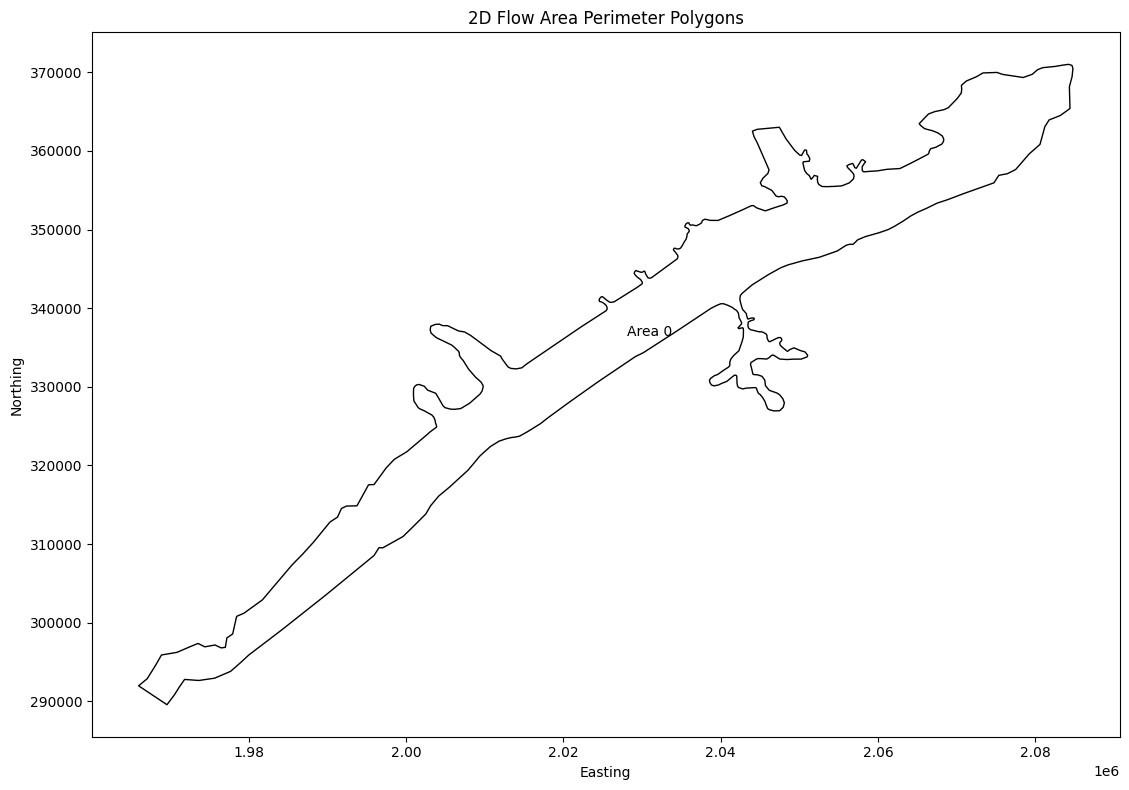

In [26]:
# Generate Map of Mesh Areas
if generate_plots:
    # Plot the 2D Flow Area Perimeter Polygons
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(12, 8))
    mesh_areas.plot(ax=ax, edgecolor='black', facecolor='none')

    # Add labels for each polygon
    for idx, row in mesh_areas.iterrows():
        centroid = row.geometry.centroid
        # Check if 'Name' column exists, otherwise use a default label
        label = row.get('Name', f'Area {idx}')
        ax.annotate(label, (centroid.x, centroid.y), ha='center', va='center')

    plt.title('2D Flow Area Perimeter Polygons')
    plt.xlabel('Easting')
    plt.ylabel('Northing')
    plt.tight_layout()
    plt.show()

In [27]:
# Get mesh cell faces as geodatframe
mesh_cell_faces_gdf = HdfMesh.get_mesh_cell_faces(geom_hdf_path)


2025-12-16 21:03:22 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:22 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:22 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:22 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:22 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:22 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:22 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:22 - ras_commander.hdf.HdfBase - INFO - Converted WKT to EPSG:2271 from HDF file BaldEagleDamBrk.g09.hdf


In [28]:
mesh_cell_faces_gdf

,mesh_name,face_id,geometry
0,BaldEagleCr,0,"LINESTRING (2042125 351625, 2042375 351625)"
1,BaldEagleCr,1,"LINESTRING (2042375 351625, 2042375 351875)"
2,BaldEagleCr,2,"LINESTRING (2042375 351875, 2042125 351875)"
3,BaldEagleCr,3,"LINESTRING (2042125 351875, 2042125 351625)"
4,BaldEagleCr,4,"LINESTRING (2042375 351375, 2042375 351625)"
...,...,...,...
37589,BaldEagleCr,37589,"LINESTRING (1978444.054 300812.794, 1978402.01..."
37590,BaldEagleCr,37590,"LINESTRING (1973531.76 297370.846, 1973246.989..."
37591,BaldEagleCr,37591,"LINESTRING (1968886.801 295900.5, 1968782.778 ..."
37592,BaldEagleCr,37592,"LINESTRING (1965981.775 291978.68, 1966280.11 ..."



Mesh Cell Faces Statistics:
Total number of cell faces: 37594
Number of unique meshes: 1


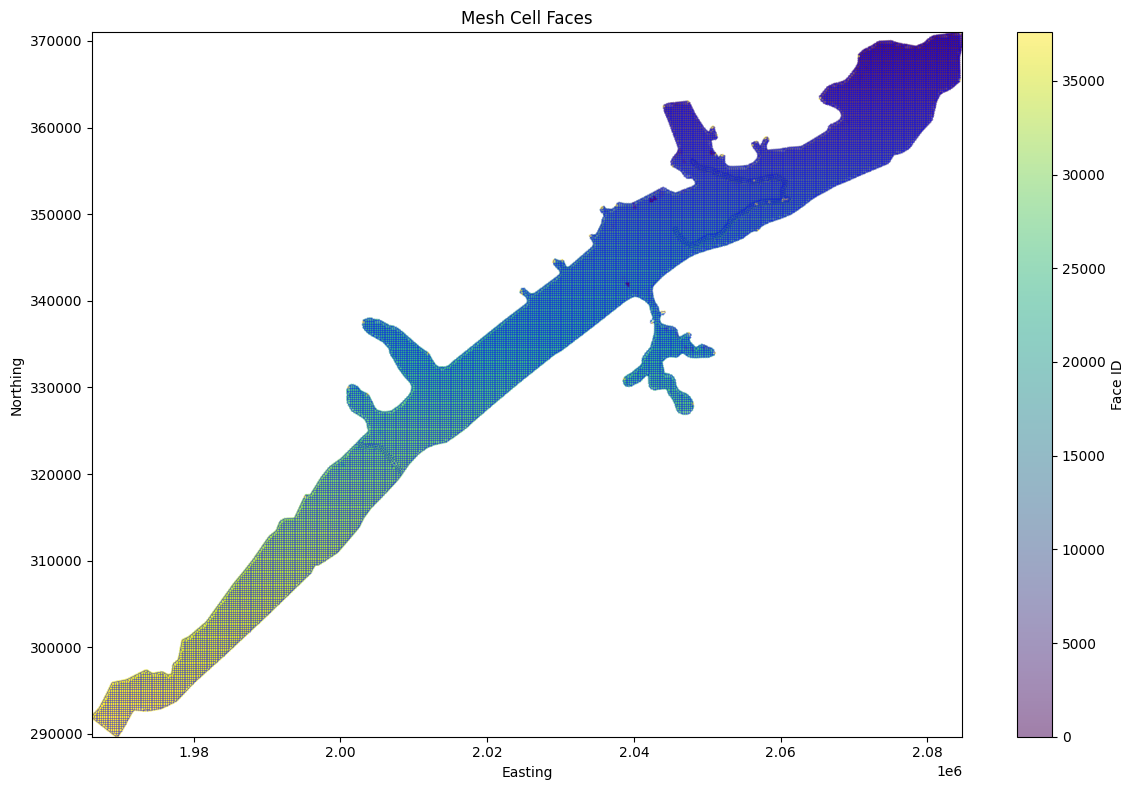

In [29]:
from matplotlib.collections import LineCollection
import numpy as np

# Calculate and display statistics
print("\nMesh Cell Faces Statistics:")
print(f"Total number of cell faces: {len(mesh_cell_faces_gdf)}")
print(f"Number of unique meshes: {mesh_cell_faces_gdf['mesh_name'].nunique()}")

if generate_maps:
    # Plot the mesh cell faces more efficiently
    fig, ax = plt.subplots(figsize=(12, 8))

    # Convert all geometries to numpy arrays at once for faster plotting
    lines = [list(zip(*line.xy)) for line in mesh_cell_faces_gdf.geometry]
    lines_collection = LineCollection(lines, colors='blue', linewidth=0.5, alpha=0.5)
    ax.add_collection(lines_collection)

    # Set plot title and labels
    plt.title('Mesh Cell Faces')
    plt.xlabel('Easting')
    plt.ylabel('Northing')

    # Calculate centroids once and store as numpy arrays
    centroids = np.array([[geom.centroid.x, geom.centroid.y] for geom in mesh_cell_faces_gdf.geometry])

    # Create scatter plot with numpy arrays
    scatter = ax.scatter(
        centroids[:, 0],
        centroids[:, 1], 
        c=mesh_cell_faces_gdf['face_id'],
        cmap='viridis',
        s=1,
        alpha=0.5
    )
    plt.colorbar(scatter, label='Face ID')

    # Set axis limits based on data bounds
    ax.set_xlim(centroids[:, 0].min(), centroids[:, 0].max())
    ax.set_ylim(centroids[:, 1].min(), centroids[:, 1].max())

    plt.tight_layout()
    plt.show()
else:
    print("generate_maps is False")


In [ ]:
# Example: Find the nearest cell face to a given point using library API
# The HdfMesh.find_nearest_face() function replaces the notebook's custom helper

print("\nExample: Finding the nearest cell face to a given point")

from shapely.geometry import Point
import geopandas as gpd

# Create a sample point (coordinates in project CRS)
# Note: Update these coordinates based on your project's extent
sample_coords = (1025677, 7853731)

# Ensure mesh_cell_faces_gdf exists from previous cell
if 'mesh_cell_faces_gdf' in dir() and not mesh_cell_faces_gdf.empty:
    # Use library API to find nearest face
    # HdfMesh.find_nearest_face(point, cell_faces_gdf, mesh_name=None) -> (face_id, distance)
    nearest_face_id, distance = HdfMesh.find_nearest_face(sample_coords, mesh_cell_faces_gdf)

    print(f"Nearest cell face to point {sample_coords}:")
    print(f"Face ID: {nearest_face_id}")
    print(f"Distance: {distance:.2f} units")

    # Visualize the result
    if nearest_face_id is not None:
        fig, ax = plt.subplots(figsize=(12, 8))

        # Plot all cell faces
        mesh_cell_faces_gdf.plot(ax=ax, color='blue', linewidth=0.5, alpha=0.5, label='Cell Faces')

        # Plot the sample point
        sample_point_gdf = gpd.GeoDataFrame(
            {'geometry': [Point(sample_coords)]},
            crs=mesh_cell_faces_gdf.crs
        )
        sample_point_gdf.plot(ax=ax, color='red', markersize=100, alpha=0.7, label='Sample Point')

        # Plot the nearest cell face
        nearest_face = mesh_cell_faces_gdf[mesh_cell_faces_gdf['face_id'] == nearest_face_id]
        nearest_face.plot(ax=ax, color='green', linewidth=2, alpha=0.7, label='Nearest Face')

        # Set labels and title
        ax.set_xlabel('X Coordinate')
        ax.set_ylabel('Y Coordinate')
        ax.set_title('Nearest Cell Face to Sample Point (using HdfMesh.find_nearest_face)')

        # Add legend and grid
        ax.legend()
        ax.grid(True)

        plt.tight_layout()
        plt.show()
else:
    print("Note: mesh_cell_faces_gdf not available - run mesh cell faces extraction cell first")


In [32]:
# Extract Cell Polygons
print("\nExample 6: Extracting Cell Polygons")
cell_polygons_df = HdfMesh.get_mesh_cell_polygons(geom_hdf_path)

2025-12-16 21:03:25 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:25 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:25 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:25 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:25 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:25 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:25 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:25 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf



Example 6: Extracting Cell Polygons


2025-12-16 21:03:26 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:26 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:26 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:26 - ras_commander.hdf.HdfBase - INFO - Converted WKT to EPSG:2271 from HDF file BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:27 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:27 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:27 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:27 - ras_commander.hdf.HdfBase - INFO - Converted WKT to EPSG:2271 from HDF file BaldEagleDamBrk.g09.hdf


In [33]:
cell_polygons_df

,mesh_name,cell_id,geometry
0,BaldEagleCr,0,"POLYGON ((2082875 370625, 2082723.922 370776.0..."
1,BaldEagleCr,1,"POLYGON ((2083125 370625, 2083125 370844.185, ..."
2,BaldEagleCr,2,"POLYGON ((2083375 370625, 2083375 370886.638, ..."
3,BaldEagleCr,3,"POLYGON ((2083625 370625, 2083625 370925.693, ..."
4,BaldEagleCr,4,"POLYGON ((2083875 370625, 2083875 370958.588, ..."
...,...,...,...
18061,BaldEagleCr,18061,"POLYGON ((2060605.501 351955.442, 2060652.06 3..."
18062,BaldEagleCr,18062,"POLYGON ((2060652.06 351777.237, 2060849.045 3..."
18063,BaldEagleCr,18063,"POLYGON ((2060875 351951.343, 2060929.66 35193..."
18064,BaldEagleCr,18064,"POLYGON ((2060991.954 351624.893, 2060964.72 3..."


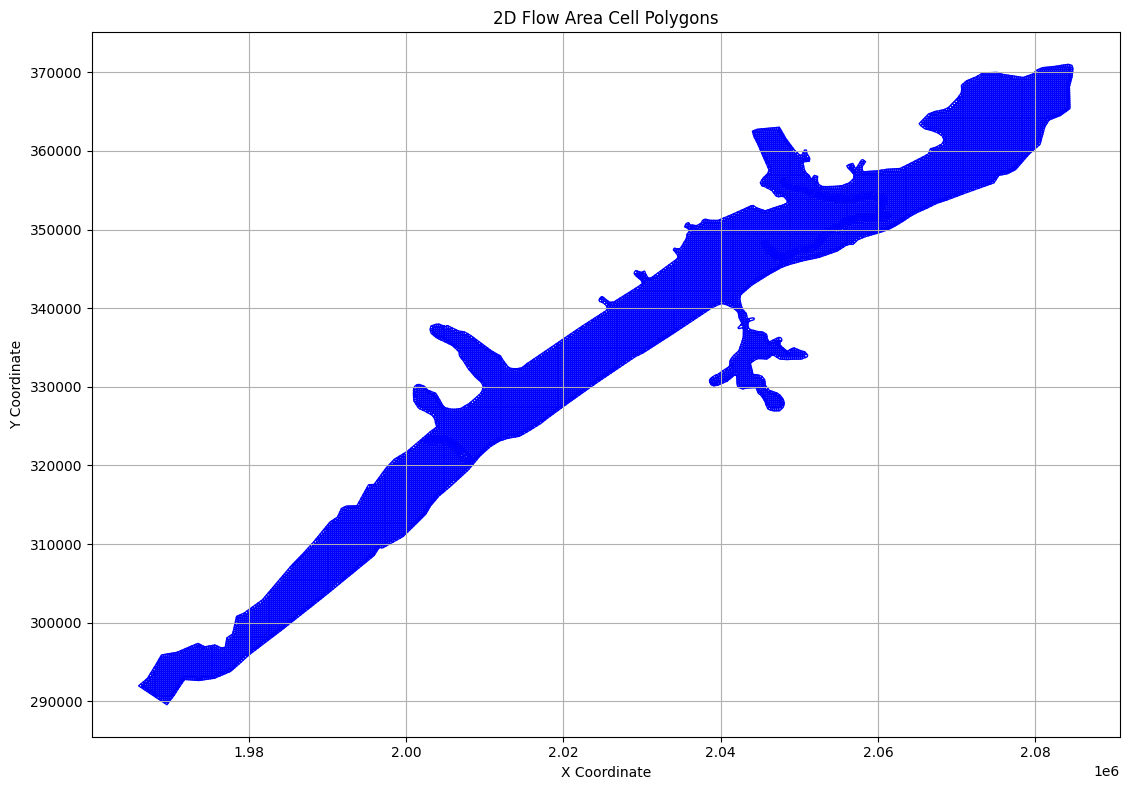

In [34]:
# Plot cell polygons

if generate_maps:
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot cell polygons
    cell_polygons_df.plot(ax=ax, edgecolor='blue', facecolor='none')

    # Set labels and title
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title('2D Flow Area Cell Polygons')

    # Add grid
    ax.grid(True)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()
else:
    print("generate_maps is set to False")


In [35]:
# Extract Cell Info
print("\nExample 5: Extracting Cell Info")
cell_info_df = HdfMesh.get_mesh_cell_points(geom_hdf_path)

2025-12-16 21:03:29 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:29 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:29 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:29 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:29 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:29 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:29 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:29 - ras_commander.hdf.HdfBase - INFO - Converted WKT to EPSG:2271 from HDF file BaldEagleDamBrk.g09.hdf



Example 5: Extracting Cell Info


In [36]:
cell_info_df

,mesh_name,cell_id,geometry
0,BaldEagleCr,0,POINT (2083000 370750)
1,BaldEagleCr,1,POINT (2083250 370750)
2,BaldEagleCr,2,POINT (2083500 370750)
3,BaldEagleCr,3,POINT (2083750 370750)
4,BaldEagleCr,4,POINT (2084000 370750)
...,...,...,...
19592,BaldEagleCr,19592,POINT (1978423.032 300718.897)
19593,BaldEagleCr,19593,POINT (1973389.375 297311.928)
19594,BaldEagleCr,19594,POINT (1968834.79 295808.861)
19595,BaldEagleCr,19595,POINT (1966130.942 291879.395)


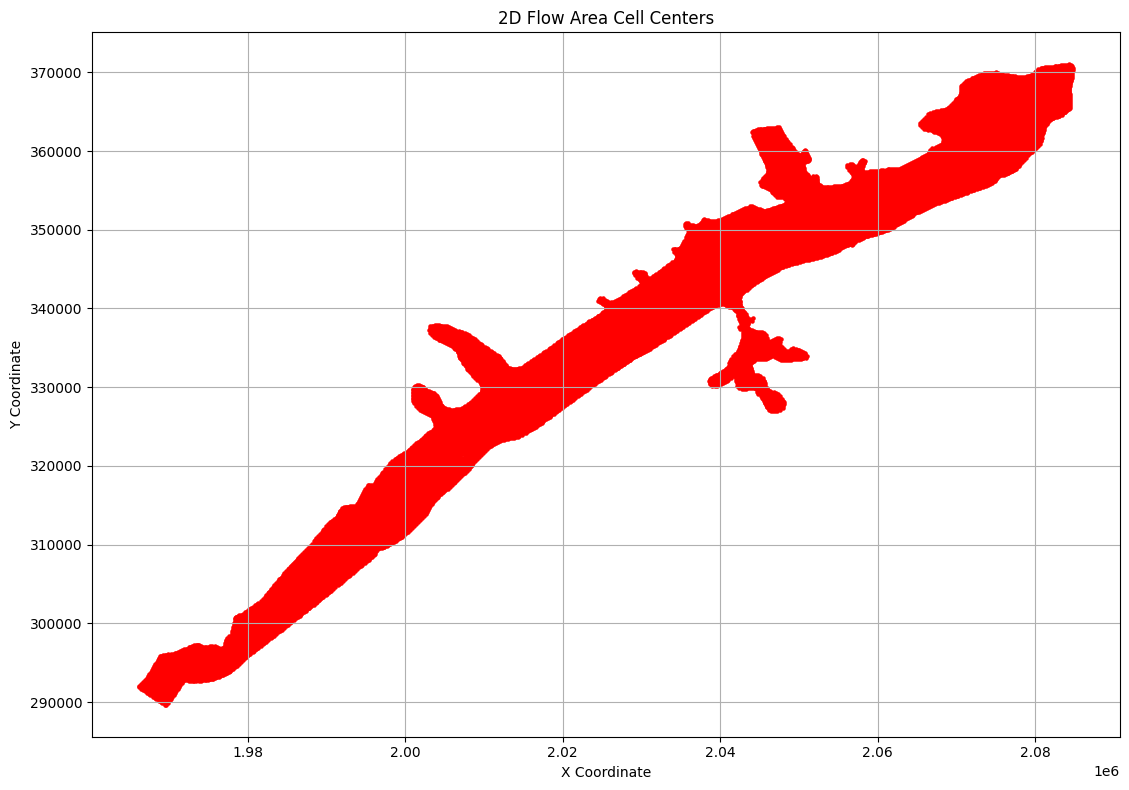

In [37]:
# Plot cell centers

if generate_maps:
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot cell centers
    cell_info_df.plot(ax=ax, color='red', markersize=5)

    # Set labels and title
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title('2D Flow Area Cell Centers')

    # Add grid
    ax.grid(True)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()
else:
    print("generate_maps is set to False")



In [39]:
# Get geometry structures attributes
print("\nGetting geometry structures attributes as Dataframe")
geom_structures_attrs = HdfStruc.get_geom_structures_attrs(geom_hdf_path)

2025-12-16 21:03:30 - ras_commander.hdf.HdfStruc - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:30 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf



Getting geometry structures attributes as Dataframe


In [40]:
geom_structures_attrs

,Bridge/Culvert Count,Connection Count,Has Bridge Opening (2D),Inline Structure Count,Lateral Structure Count
0,0,1,0,0,0


In [41]:
# TODO: Paths and Functions for each type of structure: 

# Getting geometry structures attributes
# Geometry structures attributes:
# Bridge/Culvert Count: 0
# Connection Count: 4
# Has Bridge Opening (2D): 0
# Inline Structure Count: 0
# Lateral Structure Count: 0

In [42]:
# Get boundary condition lines
print("\nExtracting Boundary Condition Lines as Geodataframe")
bc_lines_df = HdfBndry.get_bc_lines(geom_hdf_path)

2025-12-16 21:03:30 - ras_commander.hdf.HdfBndry - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:30 - ras_commander.hdf.HdfBndry - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:30 - ras_commander.hdf.HdfBase - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:30 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:30 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:30 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:30 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:30 - ras_commander.hdf.HdfBase - INFO - Converted WKT to EPSG:2271 from HDF file BaldEagleDamBrk.g09.hdf



Extracting Boundary Condition Lines as Geodataframe


In [43]:
bc_lines_df

,Name,SA-2D,Type,Length,geometry,bc_line_id
0,DSNormalDepth,BaldEagleCr,External,1801.303345,"LINESTRING (2082004.235 364024.82, 2083193.546...",0
1,DS2NormalD,BaldEagleCr,External,2633.932617,"LINESTRING (2084425.804 365392.892, 2084354.64...",1
2,Upstream Inflow,BaldEagleCr,External,2533.638672,"LINESTRING (1967473.737 290973.629, 1969582.89...",2


C:\Users\billk_clb\AppData\Local\Temp\ipykernel_27044\268397963.py:26: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


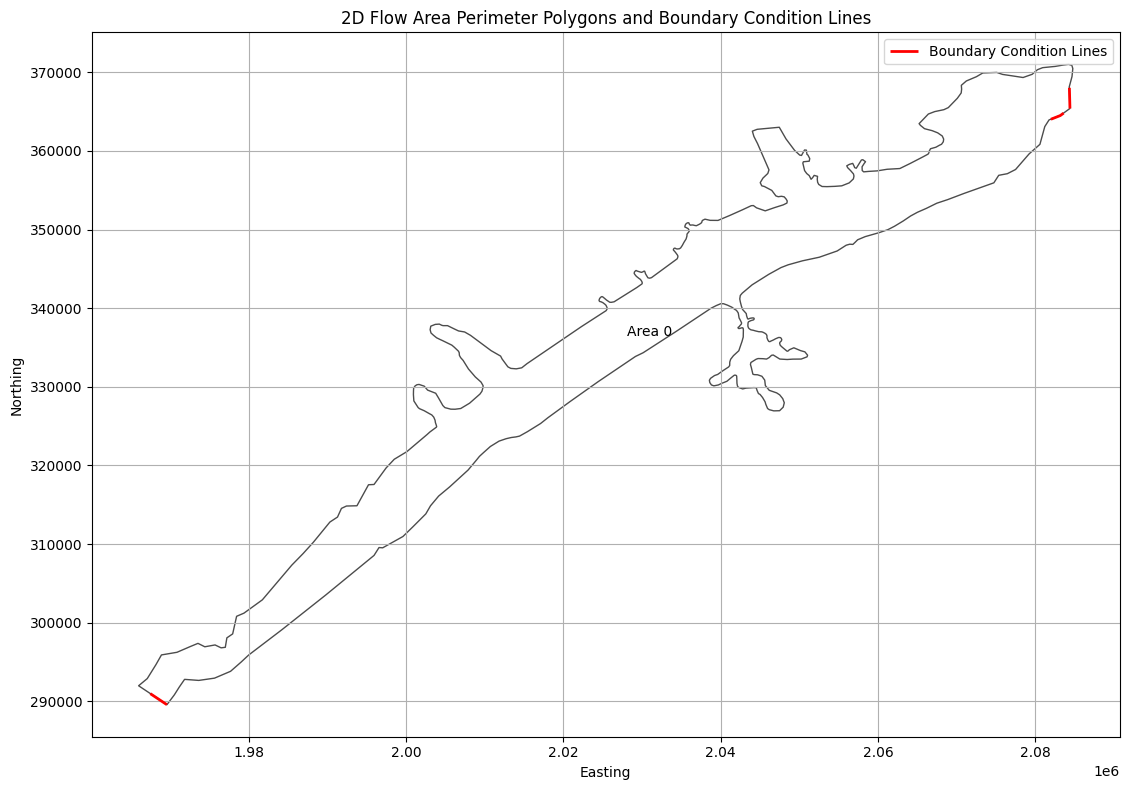

In [44]:
# Plot Boundary Condition Lines with Perimeter

if generate_maps:
    fig, ax = plt.subplots(figsize=(12, 8))

    if not mesh_areas.empty:
        mesh_areas.plot(ax=ax, edgecolor='black', facecolor='none', alpha=0.7, label='2D Flow Area')
        
        # Add labels for each polygon
        for idx, row in mesh_areas.iterrows():
            centroid = row.geometry.centroid
            label = row.get('Name', f'Area {idx}')
            ax.annotate(label, (centroid.x, centroid.y), ha='center', va='center')

    # Plot boundary condition lines
    if not bc_lines_df.empty:
        bc_lines_df.plot(ax=ax, color='red', linewidth=2, label='Boundary Condition Lines')

    # Set labels and title
    ax.set_xlabel('Easting')
    ax.set_ylabel('Northing')
    ax.set_title('2D Flow Area Perimeter Polygons and Boundary Condition Lines')

    # Add grid and legend
    ax.grid(True)
    ax.legend()

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

else:
    print("generate_maps is set to False")
# Plot 2D Flow Area Perimeter Polygons

In [45]:
# Extract Breaklines as Geodataframe
print("\nExtracting Breaklines")
breaklines_gdf = HdfBndry.get_breaklines(geom_hdf_path)


2025-12-16 21:03:30 - ras_commander.hdf.HdfBndry - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:30 - ras_commander.hdf.HdfBndry - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:30 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:30 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:30 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:30 - ras_commander.hdf.HdfBase - INFO - Converted WKT to EPSG:2271 from HDF file BaldEagleDamBrk.g09.hdf



Extracting Breaklines


In [46]:
breaklines_gdf

,bl_id,Name,geometry
0,0,SayersDam,"LINESTRING (2002361.246 323707.927, 2002741.35..."
1,1,Lower,"LINESTRING (2060356.422 351786.819, 2060316.47..."
2,2,Middle,"LINESTRING (2052757.788 348470.547, 2052785.84..."
3,3,Upper,"LINESTRING (2045597.199 348412.994, 2045638.91..."


C:\Users\billk_clb\AppData\Local\Temp\ipykernel_27044\3295158439.py:27: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


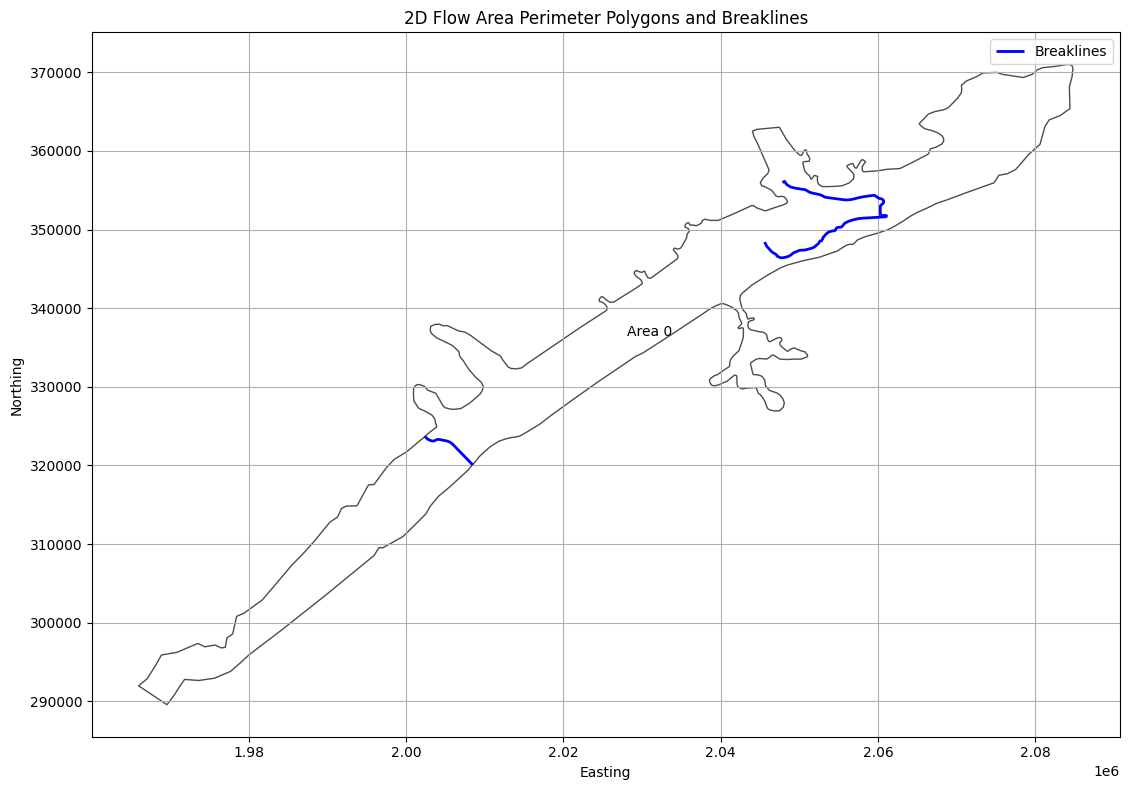

In [47]:
# Plot breaklines and 2D Flow Area Perimeter Polygons

if generate_plots:
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot 2D Flow Area Perimeter Polygons
    if not mesh_areas.empty:
        mesh_areas.plot(ax=ax, edgecolor='black', facecolor='none', alpha=0.7, label='2D Flow Area')
        
        # Add labels for each polygon
        for idx, row in mesh_areas.iterrows():
            centroid = row.geometry.centroid
            label = row.get('Name', f'Area {idx}')
            ax.annotate(label, (centroid.x, centroid.y), ha='center', va='center')

    # Plot breaklines
    if not breaklines_gdf.empty:
        breaklines_gdf.plot(ax=ax, color='blue', linewidth=2, label='Breaklines')

    # Set labels and title
    ax.set_xlabel('Easting')
    ax.set_ylabel('Northing')
    ax.set_title('2D Flow Area Perimeter Polygons and Breaklines')

    # Add grid and legend
    ax.grid(True)
    ax.legend()

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

In [48]:
# Get structures as GeoDatframe
structures_gdf = HdfStruc.get_structures(geom_hdf_path)

2025-12-16 21:03:30 - ras_commander.hdf.HdfStruc - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:30 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:30 - ras_commander.hdf.HdfBase - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:30 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:30 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:30 - ras_commander.hdf.HdfBase - INFO - Converted WKT to EPSG:2271 from HDF file BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:30 - ras_commander.hdf.HdfStruc - INFO - Successfully extracted structures GeoDataFrame.


2025-12-16 21:03:30 - ras_commander.hdf.HdfStruc - INFO - Successfully extracted structures GeoDataFrame with attributes.


In [49]:
structures_gdf

,Type,Mode,River,Reach,RS,Connection,Groupname,US Type,US River,US Reach,...,US XS Mann (Count),US BR Mann (Index),US BR Mann (Count),DS XS Mann (Index),DS XS Mann (Count),DS BR Mann (Index),DS BR Mann (Count),RC (Index),RC (Count),Profile_Data
0,Connection,Weir/Gate/Culverts,,,,Sayers Dam,"BaldEagleCr, Sayers Dam",2D,,,...,0,0,0,0,0,0,0,0,0,"[{'Station': 0.0, 'Elevation': 683.0}, {'Stati..."


In [50]:
# Get boundary condition lines as GeoDatframe
bc_lines_gdf = HdfBndry.get_bc_lines(geom_hdf_path)
print("\nBoundary Condition Lines:")

2025-12-16 21:03:30 - ras_commander.hdf.HdfBndry - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:30 - ras_commander.hdf.HdfBndry - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:30 - ras_commander.hdf.HdfBase - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:30 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:30 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:30 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:30 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:30 - ras_commander.hdf.HdfBase - INFO - Converted WKT to EPSG:2271 from HDF file BaldEagleDamBrk.g09.hdf



Boundary Condition Lines:


In [51]:
bc_lines_gdf

,Name,SA-2D,Type,Length,geometry,bc_line_id
0,DSNormalDepth,BaldEagleCr,External,1801.303345,"LINESTRING (2082004.235 364024.82, 2083193.546...",0
1,DS2NormalD,BaldEagleCr,External,2633.932617,"LINESTRING (2084425.804 365392.892, 2084354.64...",1
2,Upstream Inflow,BaldEagleCr,External,2533.638672,"LINESTRING (1967473.737 290973.629, 1969582.89...",2


### Dev Note: Need to add function for Reference Lines

In [52]:
# Get reference points as Geodataframe
ref_points_gdf = HdfBndry.get_reference_points(geom_hdf_path)

2025-12-16 21:03:30 - ras_commander.hdf.HdfBndry - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:30 - ras_commander.hdf.HdfBndry - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


In [53]:
print("\nReference Points:")
ref_points_gdf
# There are no reference points in this example project (for demonstration only)


Reference Points:


""


In [54]:
# Extract Refinement Regions
refinement_regions_df = HdfBndry.get_refinement_regions(geom_hdf_path)

2025-12-16 21:03:30 - ras_commander.hdf.HdfBndry - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:30 - ras_commander.hdf.HdfBndry - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


In [55]:
refinement_regions_df

""


In [56]:
# Plot Refinement Regions

if not refinement_regions_df.empty:
    print("Refinement Regions DataFrame:")
    display(refinement_regions_df.head())
    
    # Plot refinement regions
    fig, ax = plt.subplots(figsize=(12, 8))
    refinement_regions_df.plot(ax=ax, column='CellSize', legend=True, 
                               legend_kwds={'label': 'Cell Size', 'orientation': 'horizontal'},
                               cmap='viridis')
    ax.set_title('2D Mesh Area Refinement Regions')
    ax.set_xlabel('Easting')
    ax.set_ylabel('Northing')
    plt.tight_layout()
    plt.show()
else:
    print("No refinement regions found in the geometry file.")

# Analyze Refinement Regions
if not refinement_regions_df.empty:
    print("\nRefinement Regions Analysis:")
    print(f"Total number of refinement regions: {len(refinement_regions_df)}")
    print("\nCell Size Statistics:")
    print(refinement_regions_df['CellSize'].describe())
    
    # Group by Shape Type
    shape_type_counts = refinement_regions_df['ShapeType'].value_counts()
    print("\nRefinement Region Shape Types:")
    print(shape_type_counts)
    
    # Plot Shape Type distribution
    plt.figure(figsize=(10, 6))
    shape_type_counts.plot(kind='bar')
    plt.title('Distribution of Refinement Region Shape Types')
    plt.xlabel('Shape Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

No refinement regions found in the geometry file.


In [57]:
# Extract Plan Parameters 
plan_parameters_df = HdfPlan.get_plan_parameters(plan_hdf_path)

2025-12-16 21:03:30 - ras_commander.hdf.HdfPlan - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:30 - ras_commander.hdf.HdfPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


In [58]:
plan_parameters_df

,Plan,Parameter,Value
0,06,1D Cores,2
1,06,1D Flow Tolerance,NaN
2,06,1D Maximum Iterations,20
3,06,1D Maximum Iterations Without Improvement,0
4,06,1D Maximum Water Surface Error To Abort,100.0
5,06,1D Methodology,Finite Difference
6,06,1D Storage Area Elevation Tolerance,0.02
7,06,1D Theta,1.0
8,06,1D Theta Warmup,1.0
9,06,1D Water Surface Elevation Tolerance,0.02


In [59]:
# Extract volume accounting data
volume_accounting_df = HdfResultsPlan.get_volume_accounting(plan_hdf_path)

2025-12-16 21:03:30 - ras_commander.hdf.HdfResultsPlan - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:30 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


In [60]:
volume_accounting_df

,Error,Error Percent,Precipitation Excess (acre feet),Precipitation Excess (inches),Total Boundary Flux of Water In,Total Boundary Flux of Water Out,Vol Accounting in,Volume Ending,Volume Starting
0,0.469724,0.000332,3756.872803,1.707615,141685.0,17240.263672,Acre Feet,124445.203125,0.0


------

# RasPlanHdf Class Functions

-----

In [61]:
# Get plan start time as datetime object
start_time = HdfPlan.get_plan_start_time(plan_hdf_path)
print(f"Simulation start time: {start_time}")

2025-12-16 21:03:30 - ras_commander.hdf.HdfPlan - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:30 - ras_commander.hdf.HdfPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


Simulation start time: 2018-09-09 00:00:00


Simulation start time: 2018-09-09 00:00:00

In [62]:
# Get plan end time as datetime object
end_time = HdfPlan.get_plan_end_time(plan_hdf_path)
print(f"Simulation end time: {end_time}")

2025-12-16 21:03:30 - ras_commander.hdf.HdfPlan - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:30 - ras_commander.hdf.HdfPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


Simulation end time: 2018-09-14 00:00:00


Simulation end time: 2018-09-14 00:00:00

In [63]:
# Get maximum iteration count for mesh cells
max_iter_gdf = HdfResultsMesh.get_mesh_max_iter(plan_hdf_path)

2025-12-16 21:03:30 - ras_commander.hdf.HdfResultsMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:30 - ras_commander.hdf.HdfResultsMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:30 - ras_commander.hdf.HdfResultsMesh - INFO - Processing summary output for variable: Cell Last Iteration


2025-12-16 21:03:30 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:30 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:30 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:30 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:31 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:31 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:31 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:31 - ras_commander.hdf.HdfBase - INFO - Converted WKT to EPSG:2271 from HDF file BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:31 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:31 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:31 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:31 - ras_commander.hdf.HdfBase - INFO - Converted WKT to EPSG:2271 from HDF file BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:31 - ras_commander.hdf.HdfResultsMesh - INFO - Processed 19597 rows of summary output data


In [64]:
max_iter_gdf

,mesh_name,cell_id,cell_last_iteration,geometry
0,BaldEagleCr,0,0,POINT (2083000 370750)
1,BaldEagleCr,1,0,POINT (2083250 370750)
2,BaldEagleCr,2,0,POINT (2083500 370750)
3,BaldEagleCr,3,2,POINT (2083750 370750)
4,BaldEagleCr,4,0,POINT (2084000 370750)
...,...,...,...,...
19592,BaldEagleCr,19592,0,POINT (1978423.032 300718.897)
19593,BaldEagleCr,19593,0,POINT (1973389.375 297311.928)
19594,BaldEagleCr,19594,0,POINT (1968834.79 295808.861)
19595,BaldEagleCr,19595,0,POINT (1966130.942 291879.395)


In [65]:
# Get cell coordinates 
cell_coords = HdfMesh.get_mesh_cell_points(plan_hdf_path)


2025-12-16 21:03:31 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:31 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:31 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:31 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:31 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:31 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:31 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:31 - ras_commander.hdf.HdfBase - INFO - Converted WKT to EPSG:2271 from HDF file BaldEagleDamBrk.p06.hdf


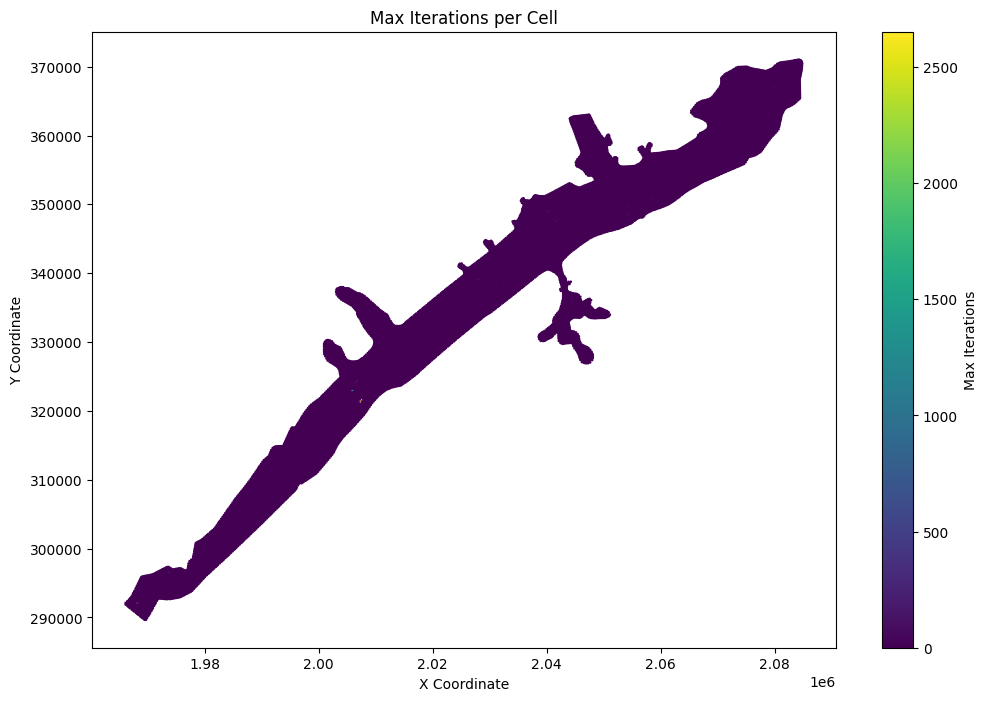


First few rows of the dataframe:


,mesh_name,cell_id,geometry
0,BaldEagleCr,0,POINT (2083000 370750)
1,BaldEagleCr,1,POINT (2083250 370750)
2,BaldEagleCr,2,POINT (2083500 370750)
3,BaldEagleCr,3,POINT (2083750 370750)
4,BaldEagleCr,4,POINT (2084000 370750)
...,...,...,...
19592,BaldEagleCr,19592,POINT (1978423.032 300718.897)
19593,BaldEagleCr,19593,POINT (1973389.375 297311.928)
19594,BaldEagleCr,19594,POINT (1968834.79 295808.861)
19595,BaldEagleCr,19595,POINT (1966130.942 291879.395)


In [66]:
# Plot Mesh Max Iterations

if generate_maps:
    # Extract x and y coordinates from the geometry column
    max_iter_gdf['x'] = max_iter_gdf['geometry'].apply(lambda geom: geom.x if geom is not None else None)
    max_iter_gdf['y'] = max_iter_gdf['geometry'].apply(lambda geom: geom.y if geom is not None else None)

    # Remove rows with None coordinates
    max_iter_gdf = max_iter_gdf.dropna(subset=['x', 'y'])

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    scatter = ax.scatter(max_iter_gdf['x'], max_iter_gdf['y'], 
                         c=max_iter_gdf['cell_last_iteration'], 
                         cmap='viridis', 
                         s=1)

    # Customize the plot
    ax.set_title('Max Iterations per Cell')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    plt.colorbar(scatter, label='Max Iterations')

    # Show the plot
    plt.show()
else:
    print("generate_maps is set to False")

# Print the first few rows of the dataframe for verification
print("\nFirst few rows of the dataframe:")
max_iter_gdf[['mesh_name', 'cell_id', 'geometry']]



In [67]:
# List top 10 points for Max Iteration per Cell
# Sort the dataframe by cell_last_iteration in descending order
top_iterations = max_iter_gdf.sort_values(by='cell_last_iteration', ascending=False).head(10)

# Create a more informative display with coordinates
print("\nTop 10 Cells with Highest Iteration Counts:")
top_iterations_display = top_iterations.copy()
top_iterations_display['x_coord'] = top_iterations_display['geometry'].apply(lambda geom: round(geom.x, 2))
top_iterations_display['y_coord'] = top_iterations_display['geometry'].apply(lambda geom: round(geom.y, 2))

# Display the results in a formatted table
print(top_iterations_display[['mesh_name', 'cell_id', 'cell_last_iteration', 'x_coord', 'y_coord']])



Top 10 Cells with Highest Iteration Counts:
         mesh_name  cell_id  cell_last_iteration     x_coord    y_coord
17721  BaldEagleCr    17721                 2652  2007386.39  321546.77
17752  BaldEagleCr    17752                  985  2005903.93  322873.01
17621  BaldEagleCr    17621                  509  1968250.00  292000.00
13520  BaldEagleCr    13520                  308  2007000.00  321250.00
13039  BaldEagleCr    13039                  194  2006750.00  324250.00
8749   BaldEagleCr     8749                  180  2028000.00  339000.00
16970  BaldEagleCr    16970                  148  1973750.00  296500.00
6415   BaldEagleCr     6415                  134  2054250.00  348500.00
6188   BaldEagleCr     6188                  133  2040250.00  349000.00
6692   BaldEagleCr     6692                  128  2041750.00  347500.00


In [68]:
# Get mesh maximum water surface elevation as Geodataframe
max_ws_gdf = HdfResultsMesh.get_mesh_max_ws(plan_hdf_path)

2025-12-16 21:03:31 - ras_commander.hdf.HdfResultsMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:31 - ras_commander.hdf.HdfResultsMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:31 - ras_commander.hdf.HdfResultsMesh - INFO - Processing summary output for variable: Maximum Water Surface


2025-12-16 21:03:31 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:31 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:31 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:31 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:31 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:31 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:31 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:31 - ras_commander.hdf.HdfBase - INFO - Converted WKT to EPSG:2271 from HDF file BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:31 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:31 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:31 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:31 - ras_commander.hdf.HdfBase - INFO - Converted WKT to EPSG:2271 from HDF file BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:31 - ras_commander.hdf.HdfResultsMesh - INFO - Processed 19597 rows of summary output data


In [69]:
# Check Dataframe Attributes (the HDF Attributes are also imported as Geoataframe Attributes)
max_ws_gdf.attrs

{'mesh_name': 'BaldEagleCr',
 'Max Time': np.float32(5.0),
 'Max Value': np.float32(848.2054),
 'Min Time': np.float32(0.99953705),
 'Min Value': np.float32(535.585),
 'Rows Variables': ['WSEL', 'Time'],
 'Units': ['ft', 'days']}

In [70]:
max_ws_gdf

,mesh_name,cell_id,maximum_water_surface,maximum_water_surface_time,geometry
0,BaldEagleCr,0,704.054443,2018-09-10 18:00:00,POINT (2083000 370750)
1,BaldEagleCr,1,692.377991,2018-09-10 18:04:00,POINT (2083250 370750)
2,BaldEagleCr,2,671.183472,2018-09-10 18:13:20,POINT (2083500 370750)
3,BaldEagleCr,3,660.605469,2018-09-10 18:54:40,POINT (2083750 370750)
4,BaldEagleCr,4,660.586243,2018-09-10 18:55:20,POINT (2084000 370750)
...,...,...,...,...,...
19592,BaldEagleCr,19592,0.000000,2018-09-09 00:00:00,POINT (1978423.032 300718.897)
19593,BaldEagleCr,19593,0.000000,2018-09-09 00:00:00,POINT (1973389.375 297311.928)
19594,BaldEagleCr,19594,0.000000,2018-09-09 00:00:00,POINT (1968834.79 295808.861)
19595,BaldEagleCr,19595,0.000000,2018-09-09 00:00:00,POINT (1966130.942 291879.395)


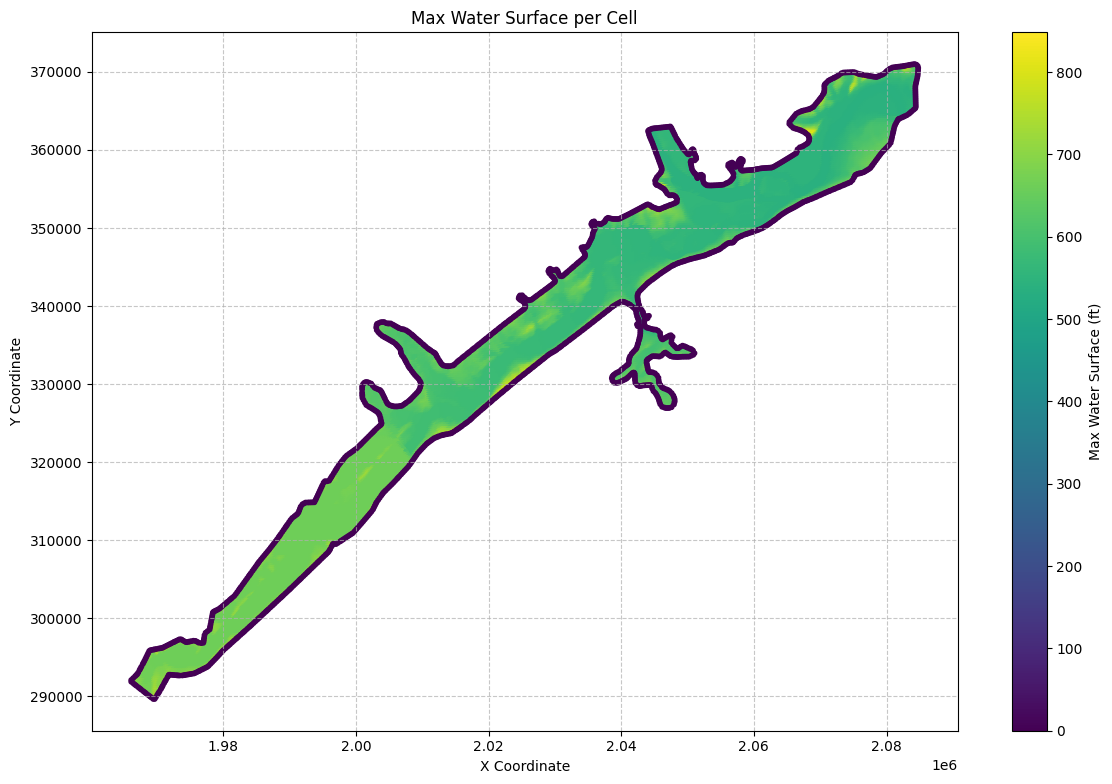

In [71]:
# Plot the max water surface as a map
if generate_maps:
    # Extract x and y coordinates from the geometry column
    max_ws_gdf['x'] = max_ws_gdf['geometry'].apply(lambda geom: geom.x if geom is not None else None)
    max_ws_gdf['y'] = max_ws_gdf['geometry'].apply(lambda geom: geom.y if geom is not None else None)

    # Remove rows with None coordinates
    max_ws_gdf = max_ws_gdf.dropna(subset=['x', 'y'])

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    scatter = ax.scatter(max_ws_gdf['x'], max_ws_gdf['y'], 
                         c=max_ws_gdf['maximum_water_surface'], 
                         cmap='viridis', 
                         s=10)

    # Customize the plot
    ax.set_title('Max Water Surface per Cell')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    plt.colorbar(scatter, label='Max Water Surface (ft)')

    # Add grid lines
    ax.grid(True, linestyle='--', alpha=0.7)

    # Increase font size for better readability
    plt.rcParams.update({'font.size': 12})

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    # Show the plot
    plt.show()
else:
    print("generate_maps is set to False")

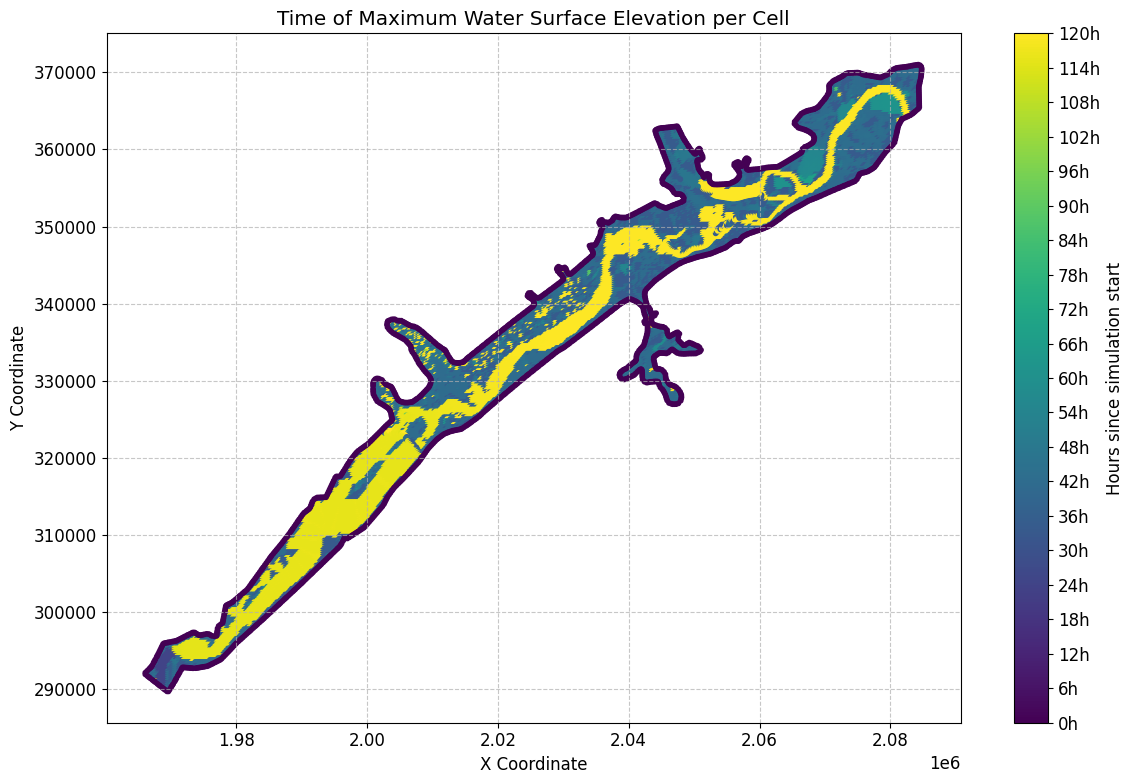


Overall Maximum WSEL: 848.21 ft
Time of Overall Maximum WSEL: 2018-09-10 17:00:00
Hours since simulation start: 41.00 hours
Location of Overall Maximum WSEL: X=1968500.0, Y=295000.0


In [72]:
# Plot the time of the max water surface elevation (WSEL)
if generate_maps:
    import matplotlib.dates as mdates
    from datetime import datetime

    # Convert the 'maximum_water_surface_time' to datetime objects
    max_ws_gdf['max_wsel_time'] = pd.to_datetime(max_ws_gdf['maximum_water_surface_time'])

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Convert datetime to hours since the start for colormap
    min_time = max_ws_gdf['max_wsel_time'].min()
    color_values = (max_ws_gdf['max_wsel_time'] - min_time).dt.total_seconds() / 3600  # Convert to hours

    scatter = ax.scatter(max_ws_gdf['x'], max_ws_gdf['y'], 
                        c=color_values, 
                        cmap='viridis', 
                        s=10)

    # Customize the plot
    ax.set_title('Time of Maximum Water Surface Elevation per Cell')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')

    # Set up the colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Hours since simulation start')

    # Format the colorbar ticks to show hours
    cbar.set_ticks(range(0, int(color_values.max()) + 1, 6))  # Set ticks every 6 hours
    cbar.set_ticklabels([f'{h}h' for h in range(0, int(color_values.max()) + 1, 6)])

    # Add grid lines
    ax.grid(True, linestyle='--', alpha=0.7)

    # Increase font size for better readability
    plt.rcParams.update({'font.size': 12})

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Find the overall maximum WSEL and its time
    max_wsel_row = max_ws_gdf.loc[max_ws_gdf['maximum_water_surface'].idxmax()]
    hours_since_start = (max_wsel_row['max_wsel_time'] - min_time).total_seconds() / 3600
    print(f"\nOverall Maximum WSEL: {max_wsel_row['maximum_water_surface']:.2f} ft")
    print(f"Time of Overall Maximum WSEL: {max_wsel_row['max_wsel_time']}")
    print(f"Hours since simulation start: {hours_since_start:.2f} hours")
    print(f"Location of Overall Maximum WSEL: X={max_wsel_row['x']}, Y={max_wsel_row['y']}")


In [73]:
# Get mesh minimum water surface elevation as geodataframe
min_ws_gdf = HdfResultsMesh.get_mesh_min_ws(plan_hdf_path)

2025-12-16 21:03:32 - ras_commander.hdf.HdfResultsMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:32 - ras_commander.hdf.HdfResultsMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:32 - ras_commander.hdf.HdfResultsMesh - INFO - Processing summary output for variable: Minimum Water Surface


2025-12-16 21:03:32 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:32 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:32 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:32 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:32 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:32 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:32 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:32 - ras_commander.hdf.HdfBase - INFO - Converted WKT to EPSG:2271 from HDF file BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:32 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:32 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:32 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:33 - ras_commander.hdf.HdfBase - INFO - Converted WKT to EPSG:2271 from HDF file BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:33 - ras_commander.hdf.HdfResultsMesh - INFO - Processed 19597 rows of summary output data


In [74]:
min_ws_gdf

,mesh_name,cell_id,minimum_water_surface,minimum_water_surface_time,geometry
0,BaldEagleCr,0,701.151245,2018-09-09 00:00:20,POINT (2083000 370750)
1,BaldEagleCr,1,689.052246,2018-09-09 00:00:20,POINT (2083250 370750)
2,BaldEagleCr,2,669.774719,2018-09-09 00:00:20,POINT (2083500 370750)
3,BaldEagleCr,3,658.986938,2018-09-09 00:00:20,POINT (2083750 370750)
4,BaldEagleCr,4,658.720581,2018-09-09 00:00:20,POINT (2084000 370750)
...,...,...,...,...,...
19592,BaldEagleCr,19592,0.000000,2018-09-09 00:00:00,POINT (1978423.032 300718.897)
19593,BaldEagleCr,19593,0.000000,2018-09-09 00:00:00,POINT (1973389.375 297311.928)
19594,BaldEagleCr,19594,0.000000,2018-09-09 00:00:00,POINT (1968834.79 295808.861)
19595,BaldEagleCr,19595,0.000000,2018-09-09 00:00:00,POINT (1966130.942 291879.395)


In [75]:
# Get mesh maximum face velocity as geodataframe
max_face_v_gdf = HdfResultsMesh.get_mesh_max_face_v(plan_hdf_path)
print("\nMesh Max Face Velocity:")

2025-12-16 21:03:33 - ras_commander.hdf.HdfResultsMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:33 - ras_commander.hdf.HdfResultsMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:33 - ras_commander.hdf.HdfResultsMesh - INFO - Processing summary output for variable: Maximum Face Velocity


2025-12-16 21:03:33 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:33 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:33 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:33 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:33 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:33 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:33 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:33 - ras_commander.hdf.HdfBase - INFO - Converted WKT to EPSG:2271 from HDF file BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:33 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:33 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:33 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:33 - ras_commander.hdf.HdfBase - INFO - Converted WKT to EPSG:2271 from HDF file BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:33 - ras_commander.hdf.HdfResultsMesh - INFO - Processed 37594 rows of summary output data



Mesh Max Face Velocity:


In [76]:
max_face_v_gdf

,mesh_name,face_id,maximum_face_velocity,maximum_face_velocity_time,geometry
0,BaldEagleCr,0,0.451430,2018-09-10 18:00:00,"LINESTRING (2042125 351625, 2042375 351625)"
1,BaldEagleCr,1,-0.887190,2018-09-10 18:00:40,"LINESTRING (2042375 351625, 2042375 351875)"
2,BaldEagleCr,2,-0.498561,2018-09-10 18:00:40,"LINESTRING (2042375 351875, 2042125 351875)"
3,BaldEagleCr,3,-0.304673,2018-09-10 18:00:40,"LINESTRING (2042125 351875, 2042125 351625)"
4,BaldEagleCr,4,-0.762405,2018-09-10 10:00:40,"LINESTRING (2042375 351375, 2042375 351625)"
...,...,...,...,...,...
37589,BaldEagleCr,37589,0.000000,2018-09-09 00:00:00,"LINESTRING (1978444.054 300812.794, 1978402.01..."
37590,BaldEagleCr,37590,0.000000,2018-09-09 00:00:00,"LINESTRING (1973531.76 297370.846, 1973246.989..."
37591,BaldEagleCr,37591,0.000000,2018-09-09 00:00:00,"LINESTRING (1968886.801 295900.5, 1968782.778 ..."
37592,BaldEagleCr,37592,0.000000,2018-09-09 00:00:00,"LINESTRING (1965981.775 291978.68, 1966280.11 ..."


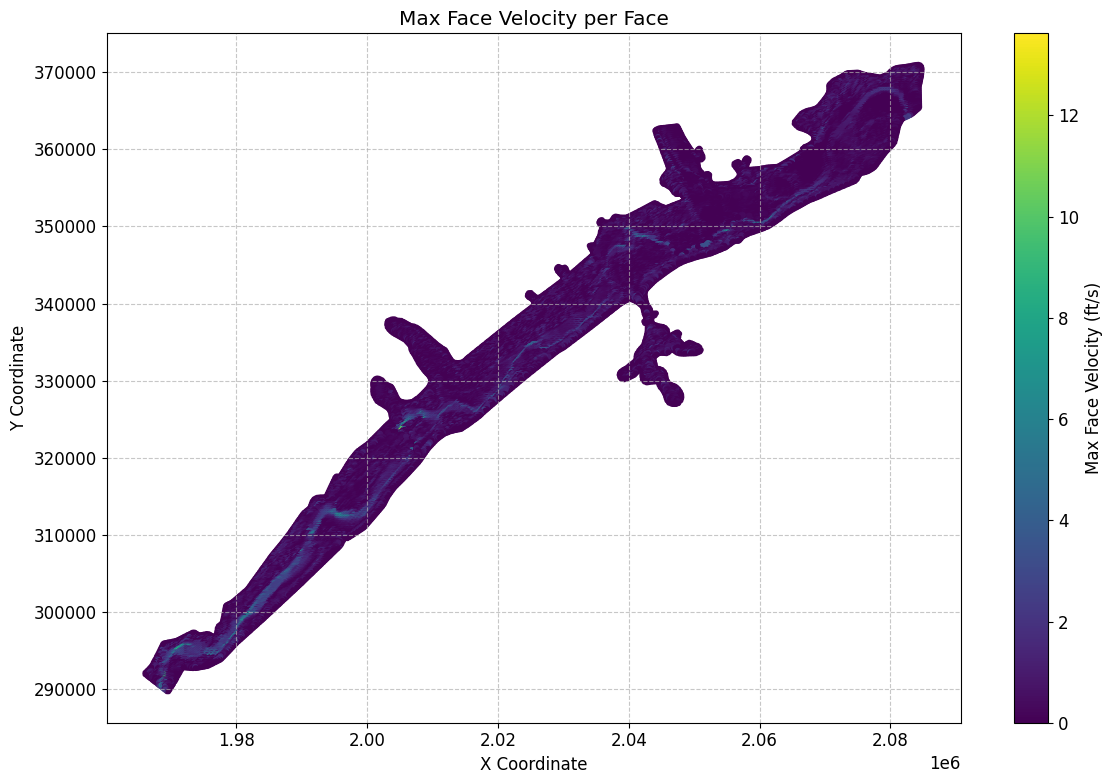

In [77]:
# Extract midpoint coordinates from the LineString geometries
max_face_v_gdf['x'] = max_face_v_gdf['geometry'].apply(lambda geom: geom.centroid.x)
max_face_v_gdf['y'] = max_face_v_gdf['geometry'].apply(lambda geom: geom.centroid.y)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(max_face_v_gdf['x'], max_face_v_gdf['y'], 
                    c=max_face_v_gdf['maximum_face_velocity'].abs(),
                    cmap='viridis',
                    s=10)

# Customize the plot
ax.set_title('Max Face Velocity per Face')
ax.set_xlabel('X Coordinate') 
ax.set_ylabel('Y Coordinate')
plt.colorbar(scatter, label='Max Face Velocity (ft/s)')

# Add grid lines
ax.grid(True, linestyle='--', alpha=0.7)

# Increase font size for better readability
plt.rcParams.update({'font.size': 12})

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

In [78]:
# Get mesh minimum face velocity as geodataframe
min_face_v_gdf = HdfResultsMesh.get_mesh_min_face_v(plan_hdf_path)


2025-12-16 21:03:34 - ras_commander.hdf.HdfResultsMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:34 - ras_commander.hdf.HdfResultsMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:34 - ras_commander.hdf.HdfResultsMesh - INFO - Processing summary output for variable: Minimum Face Velocity


2025-12-16 21:03:34 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:34 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:34 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:34 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:34 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:34 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:34 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:34 - ras_commander.hdf.HdfBase - INFO - Converted WKT to EPSG:2271 from HDF file BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:34 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:34 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:34 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:34 - ras_commander.hdf.HdfBase - INFO - Converted WKT to EPSG:2271 from HDF file BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:34 - ras_commander.hdf.HdfResultsMesh - INFO - Processed 37594 rows of summary output data


In [79]:
print("\nMesh Min Face Velocity:")
min_face_v_gdf


Mesh Min Face Velocity:


,mesh_name,face_id,minimum_face_velocity,minimum_face_velocity_time,geometry
0,BaldEagleCr,0,0.0,2018-09-09 00:00:20,"LINESTRING (2042125 351625, 2042375 351625)"
1,BaldEagleCr,1,0.0,2018-09-09 00:00:20,"LINESTRING (2042375 351625, 2042375 351875)"
2,BaldEagleCr,2,0.0,2018-09-09 00:00:20,"LINESTRING (2042375 351875, 2042125 351875)"
3,BaldEagleCr,3,0.0,2018-09-09 00:00:20,"LINESTRING (2042125 351875, 2042125 351625)"
4,BaldEagleCr,4,0.0,2018-09-09 00:00:20,"LINESTRING (2042375 351375, 2042375 351625)"
...,...,...,...,...,...
37589,BaldEagleCr,37589,0.0,2018-09-09 00:00:20,"LINESTRING (1978444.054 300812.794, 1978402.01..."
37590,BaldEagleCr,37590,0.0,2018-09-09 00:00:20,"LINESTRING (1973531.76 297370.846, 1973246.989..."
37591,BaldEagleCr,37591,0.0,2018-09-09 00:00:20,"LINESTRING (1968886.801 295900.5, 1968782.778 ..."
37592,BaldEagleCr,37592,0.0,2018-09-09 00:00:20,"LINESTRING (1965981.775 291978.68, 1966280.11 ..."


In [80]:
# Get mesh max water surface error as geodataframe

max_ws_err_gdf = HdfResultsMesh.get_mesh_max_ws_err(plan_hdf_path)


2025-12-16 21:03:34 - ras_commander.hdf.HdfResultsMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:34 - ras_commander.hdf.HdfResultsMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:34 - ras_commander.hdf.HdfResultsMesh - INFO - Processing summary output for variable: Cell Maximum Water Surface Error


2025-12-16 21:03:34 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:34 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:34 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:34 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:35 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:35 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:35 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:35 - ras_commander.hdf.HdfBase - INFO - Converted WKT to EPSG:2271 from HDF file BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:35 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:35 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:35 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:35 - ras_commander.hdf.HdfBase - INFO - Converted WKT to EPSG:2271 from HDF file BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:35 - ras_commander.hdf.HdfResultsMesh - INFO - Processed 19597 rows of summary output data


In [81]:
print("\nMesh Max Water Surface Error:")
max_ws_err_gdf



Mesh Max Water Surface Error:


,mesh_name,cell_id,cell_maximum_water_surface_error,cell_maximum_water_surface_error_time,geometry
0,BaldEagleCr,0,0.000206,2018-09-11 20:50:00,POINT (2083000 370750)
1,BaldEagleCr,1,0.001100,2018-09-10 21:38:00,POINT (2083250 370750)
2,BaldEagleCr,2,0.000795,2018-09-10 09:58:40,POINT (2083500 370750)
3,BaldEagleCr,3,0.000314,2018-09-10 17:00:40,POINT (2083750 370750)
4,BaldEagleCr,4,0.001795,2018-09-10 09:28:00,POINT (2084000 370750)
...,...,...,...,...,...
19592,BaldEagleCr,19592,0.000000,2018-09-09 00:00:00,POINT (1978423.032 300718.897)
19593,BaldEagleCr,19593,0.000000,2018-09-09 00:00:00,POINT (1973389.375 297311.928)
19594,BaldEagleCr,19594,0.000000,2018-09-09 00:00:00,POINT (1968834.79 295808.861)
19595,BaldEagleCr,19595,0.000000,2018-09-09 00:00:00,POINT (1966130.942 291879.395)


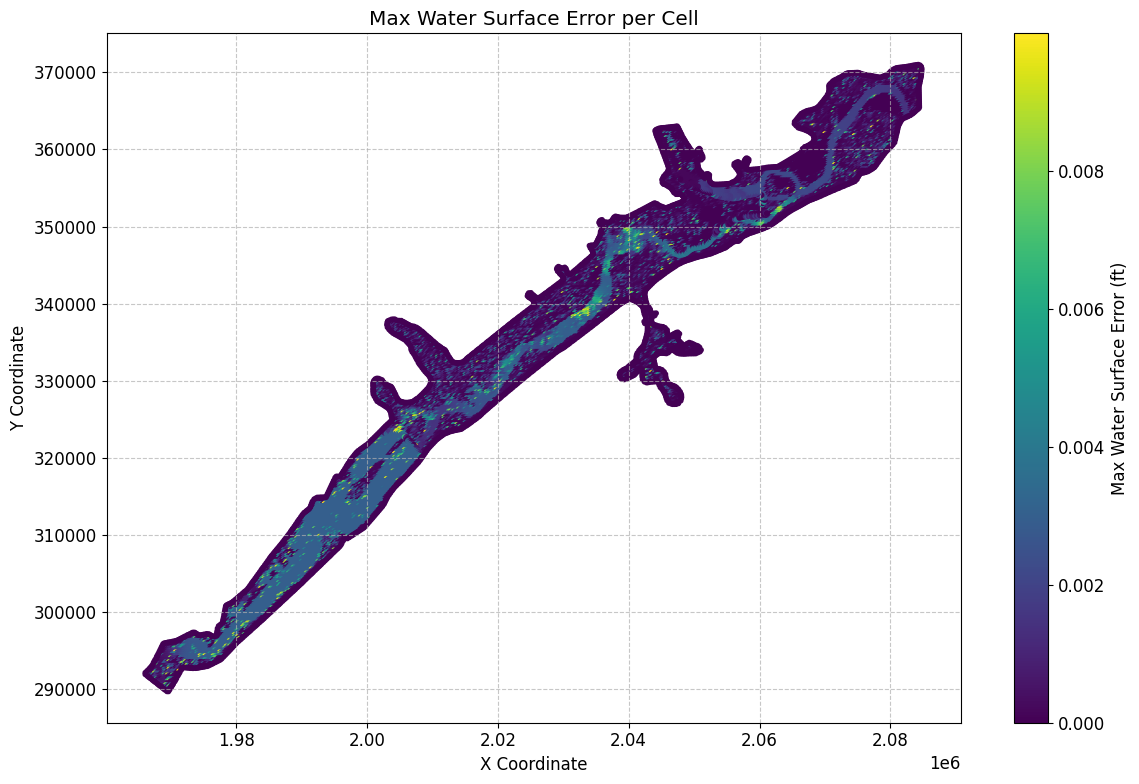

In [82]:
# Plot max water surface error

if generate_maps:
# Extract x and y coordinates from the geometry points, handling None values
    max_ws_err_gdf['x'] = max_ws_err_gdf['geometry'].apply(lambda geom: geom.x if geom is not None else None)
    max_ws_err_gdf['y'] = max_ws_err_gdf['geometry'].apply(lambda geom: geom.y if geom is not None else None)

    # Remove any rows with None coordinates
    max_ws_err_gdf = max_ws_err_gdf.dropna(subset=['x', 'y'])

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    scatter = ax.scatter(max_ws_err_gdf['x'], max_ws_err_gdf['y'],
                        c=max_ws_err_gdf['cell_maximum_water_surface_error'],
                        cmap='viridis',
                        s=10)

    # Customize the plot
    ax.set_title('Max Water Surface Error per Cell')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    plt.colorbar(scatter, label='Max Water Surface Error (ft)')

    # Add grid lines
    ax.grid(True, linestyle='--', alpha=0.7)

    # Increase font size for better readability
    plt.rcParams.update({'font.size': 12})

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    # Show the plot
    plt.show()

In [83]:
# Sort Dataframe to show top 10 maximum water surface errors:
max_ws_err_gdf_sorted = max_ws_err_gdf.sort_values(by='cell_maximum_water_surface_error', ascending=False)


In [84]:
print("\nTop 10 maximum water surface errors:")
max_ws_err_gdf_sorted


Top 10 maximum water surface errors:


,mesh_name,cell_id,cell_maximum_water_surface_error,cell_maximum_water_surface_error_time,geometry,x,y
1709,BaldEagleCr,1709,0.009991,2018-09-10 09:06:40,POINT (2077250 362750),2.077250e+06,362750.000000
12789,BaldEagleCr,12789,0.009980,2018-09-12 07:43:20,POINT (2008250 325500),2.008250e+06,325500.000000
5967,BaldEagleCr,5967,0.009940,2018-09-12 21:01:20,POINT (2055000 349750),2.055000e+06,349750.000000
13627,BaldEagleCr,13627,0.009938,2018-09-11 23:23:20,POINT (2004250 320500),2.004250e+06,320500.000000
1882,BaldEagleCr,1882,0.009926,2018-09-10 10:25:20,POINT (2070000 362000),2.070000e+06,362000.000000
...,...,...,...,...,...,...,...
19376,BaldEagleCr,19376,0.000000,2018-09-09 00:00:00,POINT (1980950.412 302350.529),1.980950e+06,302350.529195
19377,BaldEagleCr,19377,0.000000,2018-09-09 00:00:00,POINT (1990076.021 303763.106),1.990076e+06,303763.106097
19378,BaldEagleCr,19378,0.000000,2018-09-09 00:00:00,POINT (1982502.513 303830.235),1.982503e+06,303830.234704
19379,BaldEagleCr,19379,0.000000,2018-09-09 00:00:00,POINT (1989889.605 303610.306),1.989890e+06,303610.306187


In [85]:
# Get mesh summary output for other Datasets (here we retrieve Maximum Face Courant) as geodataframe
max_courant_gdf = HdfResultsMesh.get_mesh_summary(plan_hdf_path, var="Maximum Face Courant")

2025-12-16 21:03:35 - ras_commander.hdf.HdfResultsMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:35 - ras_commander.hdf.HdfResultsMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:35 - ras_commander.hdf.HdfResultsMesh - INFO - Processing summary output for variable: Maximum Face Courant


2025-12-16 21:03:35 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:35 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:35 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:35 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:36 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:36 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:36 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:36 - ras_commander.hdf.HdfBase - INFO - Converted WKT to EPSG:2271 from HDF file BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:36 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:36 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:36 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:36 - ras_commander.hdf.HdfBase - INFO - Converted WKT to EPSG:2271 from HDF file BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:36 - ras_commander.hdf.HdfResultsMesh - INFO - Processed 37594 rows of summary output data


In [86]:
print("\nMesh Summary Output (Maximum Courant):")
max_courant_gdf.attrs


Mesh Summary Output (Maximum Courant):


{'mesh_name': 'BaldEagleCr',
 'Can Interpolate': 'False',
 'Can Plot': 'True',
 'Coverage': 'Average',
 'Location': 'Faces',
 'Maximum Value of Data Set': np.float32(0.6819884),
 'Minimum Value of Data Set': np.float32(0.0),
 'Name': 'Face Courant Maximum',
 'Orientation': 'Scalar',
 'Row': np.int32(0),
 'Rows Variables': ['Courant Face', 'Time'],
 'Units': 'vel*dt/length',
 'Units per row': ['vel*dt/length', 'days']}

In [87]:
max_courant_gdf

,mesh_name,face_id,maximum_face_courant,maximum_face_courant_time,geometry
0,BaldEagleCr,0,0.000020,2018-09-09 11:03:20,"LINESTRING (2042125 351625, 2042375 351625)"
1,BaldEagleCr,1,0.000062,2018-09-09 11:32:40,"LINESTRING (2042375 351625, 2042375 351875)"
2,BaldEagleCr,2,0.000048,2018-09-10 07:02:40,"LINESTRING (2042375 351875, 2042125 351875)"
3,BaldEagleCr,3,0.000016,2018-09-09 11:03:20,"LINESTRING (2042125 351875, 2042125 351625)"
4,BaldEagleCr,4,0.000062,2018-09-09 11:05:20,"LINESTRING (2042375 351375, 2042375 351625)"
...,...,...,...,...,...
37589,BaldEagleCr,37589,0.000000,2018-09-09 00:00:00,"LINESTRING (1978444.054 300812.794, 1978402.01..."
37590,BaldEagleCr,37590,0.000000,2018-09-09 00:00:00,"LINESTRING (1973531.76 297370.846, 1973246.989..."
37591,BaldEagleCr,37591,0.000000,2018-09-09 00:00:00,"LINESTRING (1968886.801 295900.5, 1968782.778 ..."
37592,BaldEagleCr,37592,0.000000,2018-09-09 00:00:00,"LINESTRING (1965981.775 291978.68, 1966280.11 ..."


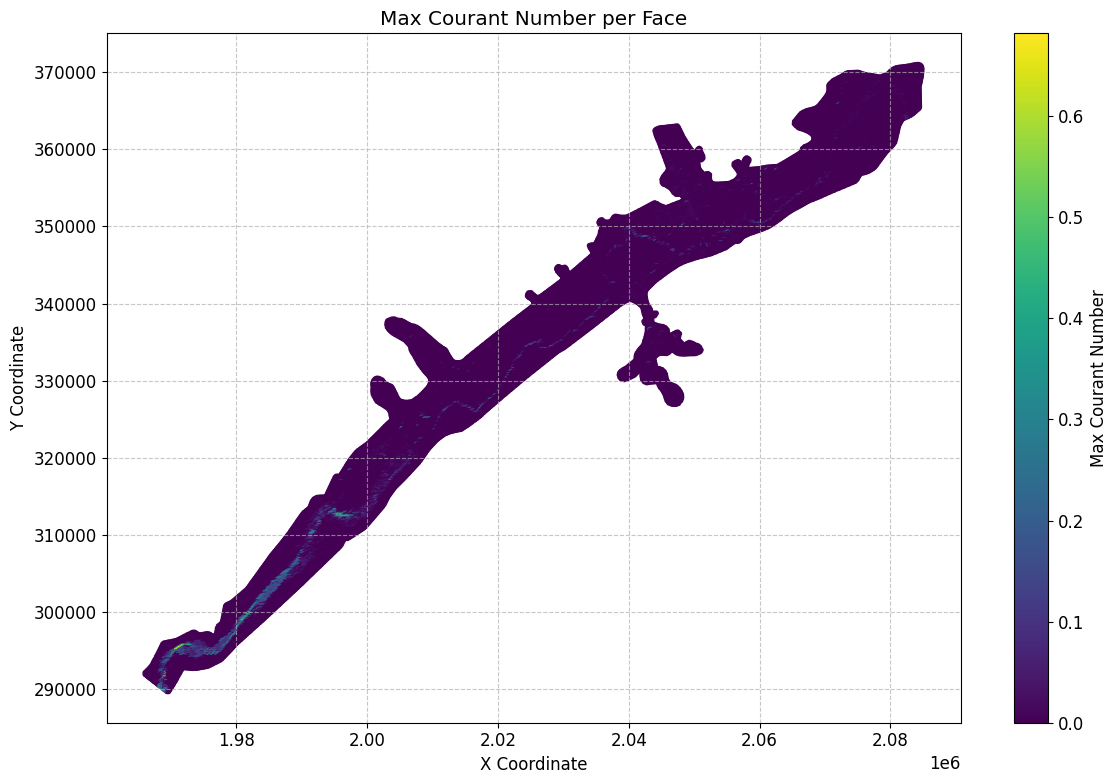


First few rows of the Courant number dataframe:


,mesh_name,face_id,maximum_face_courant,maximum_face_courant_time,geometry,centroid,x,y
0,BaldEagleCr,0,0.000020,2018-09-09 11:03:20,"LINESTRING (2042125 351625, 2042375 351625)",POINT (2042250 351625),2.042250e+06,351625.000000
1,BaldEagleCr,1,0.000062,2018-09-09 11:32:40,"LINESTRING (2042375 351625, 2042375 351875)",POINT (2042375 351750),2.042375e+06,351750.000000
2,BaldEagleCr,2,0.000048,2018-09-10 07:02:40,"LINESTRING (2042375 351875, 2042125 351875)",POINT (2042250 351875),2.042250e+06,351875.000000
3,BaldEagleCr,3,0.000016,2018-09-09 11:03:20,"LINESTRING (2042125 351875, 2042125 351625)",POINT (2042125 351750),2.042125e+06,351750.000000
4,BaldEagleCr,4,0.000062,2018-09-09 11:05:20,"LINESTRING (2042375 351375, 2042375 351625)",POINT (2042375 351500),2.042375e+06,351500.000000
...,...,...,...,...,...,...,...,...
37589,BaldEagleCr,37589,0.000000,2018-09-09 00:00:00,"LINESTRING (1978444.054 300812.794, 1978402.01...",POINT (1978423.032 300718.897),1.978423e+06,300718.897016
37590,BaldEagleCr,37590,0.000000,2018-09-09 00:00:00,"LINESTRING (1973531.76 297370.846, 1973246.989...",POINT (1973389.375 297311.928),1.973389e+06,297311.928472
37591,BaldEagleCr,37591,0.000000,2018-09-09 00:00:00,"LINESTRING (1968886.801 295900.5, 1968782.778 ...",POINT (1968834.79 295808.861),1.968835e+06,295808.860743
37592,BaldEagleCr,37592,0.000000,2018-09-09 00:00:00,"LINESTRING (1965981.775 291978.68, 1966280.11 ...",POINT (1966130.942 291879.395),1.966131e+06,291879.394946


In [88]:
# Plot max Courant number

# Convert to GeoDataFrame if not empty
if not max_courant_gdf.empty:
    if generate_maps:
        # Get centroids of line geometries for plotting
        max_courant_gdf['centroid'] = max_courant_gdf.geometry.centroid
        max_courant_gdf['x'] = max_courant_gdf.centroid.x
        max_courant_gdf['y'] = max_courant_gdf.centroid.y

        # Create the plot
        fig, ax = plt.subplots(figsize=(12, 8))
        scatter = ax.scatter(max_courant_gdf['x'], max_courant_gdf['y'],
                        c=max_courant_gdf['maximum_face_courant'],
                        cmap='viridis',
                        s=10)

        # Customize the plot
        ax.set_title('Max Courant Number per Face')
        ax.set_xlabel('X Coordinate')
        ax.set_ylabel('Y Coordinate')
        plt.colorbar(scatter, label='Max Courant Number')

        # Add grid lines
        ax.grid(True, linestyle='--', alpha=0.7)

        # Increase font size for better readability
        plt.rcParams.update({'font.size': 12})

        # Adjust layout to prevent cutting off labels
        plt.tight_layout()

        # Show the plot
        plt.show()

# Print the first few rows of the dataframe for verification
print("\nFirst few rows of the Courant number dataframe:")
max_courant_gdf


In [89]:
# Get mesh summary output for other Datasets (here we retrieve Maximum Face Courant)

max_face_shear_gdf = HdfResultsMesh.get_mesh_summary(plan_hdf_path, var="Maximum Face Shear Stress")

2025-12-16 21:03:36 - ras_commander.hdf.HdfResultsMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:36 - ras_commander.hdf.HdfResultsMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:36 - ras_commander.hdf.HdfResultsMesh - INFO - Processing summary output for variable: Maximum Face Shear Stress


2025-12-16 21:03:36 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:36 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:36 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:36 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:37 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:37 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:37 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:37 - ras_commander.hdf.HdfBase - INFO - Converted WKT to EPSG:2271 from HDF file BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:37 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:37 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:37 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:37 - ras_commander.hdf.HdfBase - INFO - Converted WKT to EPSG:2271 from HDF file BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:37 - ras_commander.hdf.HdfResultsMesh - INFO - Processed 37594 rows of summary output data


In [90]:
print("\nMesh Summary Output (Maximum Face Shear Stress:")
print(max_face_shear_gdf.attrs)


Mesh Summary Output (Maximum Face Shear Stress:
{'mesh_name': 'BaldEagleCr', 'Max Time': np.float32(0.0), 'Max Value': np.float32(0.0), 'Min Time': np.float32(0.0), 'Min Value': np.float32(0.0), 'Rows Variables': ['Shear Stress', 'Time'], 'Units': ['PSF', 'days']}


In [91]:
max_face_shear_gdf

,mesh_name,face_id,maximum_face_shear_stress,maximum_face_shear_stress_time,geometry
0,BaldEagleCr,0,0.0,2018-09-09,"LINESTRING (2042125 351625, 2042375 351625)"
1,BaldEagleCr,1,0.0,2018-09-09,"LINESTRING (2042375 351625, 2042375 351875)"
2,BaldEagleCr,2,0.0,2018-09-09,"LINESTRING (2042375 351875, 2042125 351875)"
3,BaldEagleCr,3,0.0,2018-09-09,"LINESTRING (2042125 351875, 2042125 351625)"
4,BaldEagleCr,4,0.0,2018-09-09,"LINESTRING (2042375 351375, 2042375 351625)"
...,...,...,...,...,...
37589,BaldEagleCr,37589,0.0,2018-09-09,"LINESTRING (1978444.054 300812.794, 1978402.01..."
37590,BaldEagleCr,37590,0.0,2018-09-09,"LINESTRING (1973531.76 297370.846, 1973246.989..."
37591,BaldEagleCr,37591,0.0,2018-09-09,"LINESTRING (1968886.801 295900.5, 1968782.778 ..."
37592,BaldEagleCr,37592,0.0,2018-09-09,"LINESTRING (1965981.775 291978.68, 1966280.11 ..."


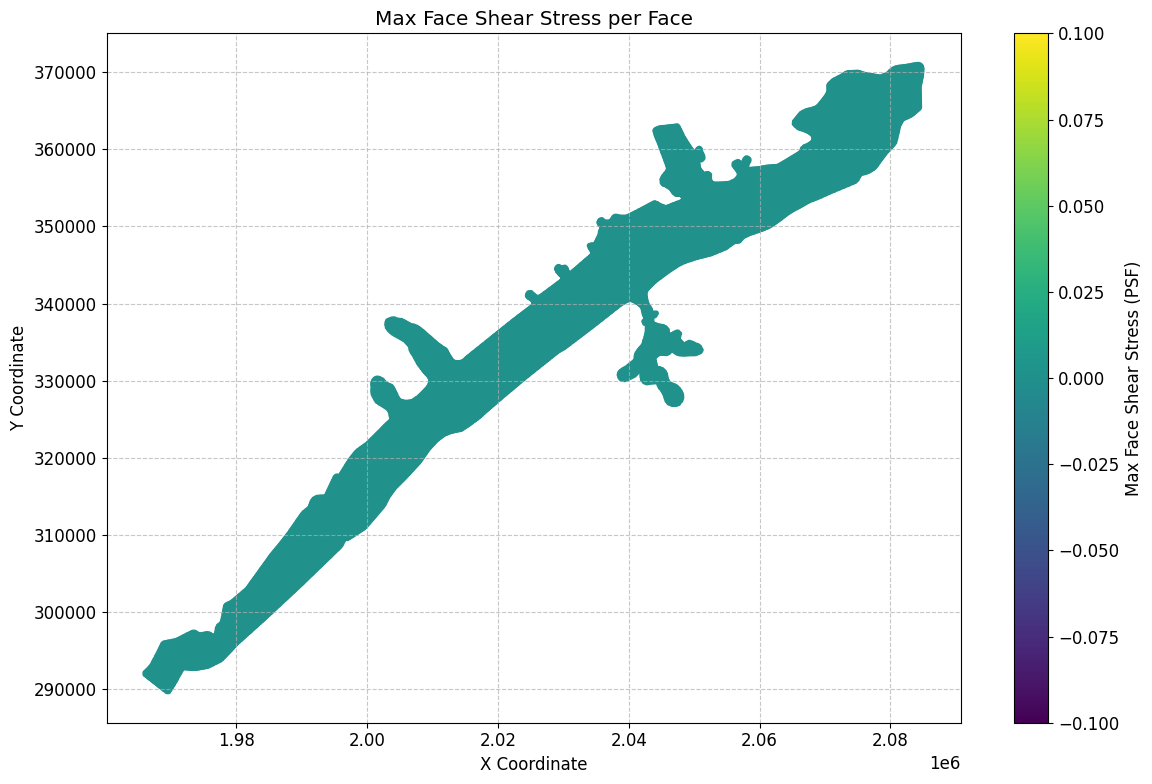

In [92]:
# Plot max face shear stress

if generate_maps and not max_face_shear_gdf.empty:
    # Calculate centroids of the line geometries and extract coordinates
    max_face_shear_gdf['centroid'] = max_face_shear_gdf['geometry'].apply(lambda line: line.centroid)
    max_face_shear_gdf['x'] = max_face_shear_gdf['centroid'].apply(lambda point: point.x)
    max_face_shear_gdf['y'] = max_face_shear_gdf['centroid'].apply(lambda point: point.y)

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    scatter = ax.scatter(max_face_shear_gdf['x'], max_face_shear_gdf['y'],
                        c=max_face_shear_gdf['maximum_face_shear_stress'],
                        cmap='viridis',
                        s=10)

    # Customize the plot
    ax.set_title('Max Face Shear Stress per Face')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    plt.colorbar(scatter, label='Max Face Shear Stress (PSF)')

    # Add grid lines
    ax.grid(True, linestyle='--', alpha=0.7)

    # Increase font size for better readability
    plt.rcParams.update({'font.size': 12})

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    # Show the plot
    plt.show()

In [93]:
# Get mesh summary output for Minimum Water Surface as geodataframe
summary_gdf_min_ws = HdfResultsMesh.get_mesh_summary(plan_hdf_path, var="Minimum Water Surface")

2025-12-16 21:03:38 - ras_commander.hdf.HdfResultsMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfResultsMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfResultsMesh - INFO - Processing summary output for variable: Minimum Water Surface


2025-12-16 21:03:38 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfBase - INFO - Converted WKT to EPSG:2271 from HDF file BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfBase - INFO - Converted WKT to EPSG:2271 from HDF file BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfResultsMesh - INFO - Processed 19597 rows of summary output data


In [94]:
print("\nMesh Summary Output (Minimum Water Surface):")
summary_gdf_min_ws


Mesh Summary Output (Minimum Water Surface):


,mesh_name,cell_id,minimum_water_surface,minimum_water_surface_time,geometry
0,BaldEagleCr,0,701.151245,2018-09-09 00:00:20,POINT (2083000 370750)
1,BaldEagleCr,1,689.052246,2018-09-09 00:00:20,POINT (2083250 370750)
2,BaldEagleCr,2,669.774719,2018-09-09 00:00:20,POINT (2083500 370750)
3,BaldEagleCr,3,658.986938,2018-09-09 00:00:20,POINT (2083750 370750)
4,BaldEagleCr,4,658.720581,2018-09-09 00:00:20,POINT (2084000 370750)
...,...,...,...,...,...
19592,BaldEagleCr,19592,0.000000,2018-09-09 00:00:00,POINT (1978423.032 300718.897)
19593,BaldEagleCr,19593,0.000000,2018-09-09 00:00:00,POINT (1973389.375 297311.928)
19594,BaldEagleCr,19594,0.000000,2018-09-09 00:00:00,POINT (1968834.79 295808.861)
19595,BaldEagleCr,19595,0.000000,2018-09-09 00:00:00,POINT (1966130.942 291879.395)


In [95]:
# Get mesh summary output for Minimum Face Velocity as geodataframe
summary_gdf_min_fv = HdfResultsMesh.get_mesh_summary(plan_hdf_path, var="Minimum Face Velocity")

2025-12-16 21:03:38 - ras_commander.hdf.HdfResultsMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfResultsMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfResultsMesh - INFO - Processing summary output for variable: Minimum Face Velocity


2025-12-16 21:03:38 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfBase - INFO - Converted WKT to EPSG:2271 from HDF file BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfBase - INFO - Converted WKT to EPSG:2271 from HDF file BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfResultsMesh - INFO - Processed 37594 rows of summary output data


In [96]:
print("\nMesh Summary Output (Minimum Face Velocity):")
summary_gdf_min_fv


Mesh Summary Output (Minimum Face Velocity):


,mesh_name,face_id,minimum_face_velocity,minimum_face_velocity_time,geometry
0,BaldEagleCr,0,0.0,2018-09-09 00:00:20,"LINESTRING (2042125 351625, 2042375 351625)"
1,BaldEagleCr,1,0.0,2018-09-09 00:00:20,"LINESTRING (2042375 351625, 2042375 351875)"
2,BaldEagleCr,2,0.0,2018-09-09 00:00:20,"LINESTRING (2042375 351875, 2042125 351875)"
3,BaldEagleCr,3,0.0,2018-09-09 00:00:20,"LINESTRING (2042125 351875, 2042125 351625)"
4,BaldEagleCr,4,0.0,2018-09-09 00:00:20,"LINESTRING (2042375 351375, 2042375 351625)"
...,...,...,...,...,...
37589,BaldEagleCr,37589,0.0,2018-09-09 00:00:20,"LINESTRING (1978444.054 300812.794, 1978402.01..."
37590,BaldEagleCr,37590,0.0,2018-09-09 00:00:20,"LINESTRING (1973531.76 297370.846, 1973246.989..."
37591,BaldEagleCr,37591,0.0,2018-09-09 00:00:20,"LINESTRING (1968886.801 295900.5, 1968782.778 ..."
37592,BaldEagleCr,37592,0.0,2018-09-09 00:00:20,"LINESTRING (1965981.775 291978.68, 1966280.11 ..."


In [97]:
# Get mesh summary output for Cell Cumulative Iteration as geodataframe
summary_gdf_cum_iter = HdfResultsMesh.get_mesh_summary(plan_hdf_path, var="Cell Cumulative Iteration")

2025-12-16 21:03:38 - ras_commander.hdf.HdfResultsMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfResultsMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfResultsMesh - INFO - Processing summary output for variable: Cell Cumulative Iteration


2025-12-16 21:03:38 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfBase - INFO - Converted WKT to EPSG:2271 from HDF file BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfBase - INFO - Converted WKT to EPSG:2271 from HDF file BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfResultsMesh - INFO - Processed 19597 rows of summary output data


In [98]:
print("\nMesh Summary Output (Cell Cumulative Iteration):")
summary_gdf_cum_iter


Mesh Summary Output (Cell Cumulative Iteration):


,mesh_name,cell_id,cell_cumulative_iteration,geometry
0,BaldEagleCr,0,0.0,POINT (2083000 370750)
1,BaldEagleCr,1,0.0,POINT (2083250 370750)
2,BaldEagleCr,2,0.0,POINT (2083500 370750)
3,BaldEagleCr,3,0.0,POINT (2083750 370750)
4,BaldEagleCr,4,0.0,POINT (2084000 370750)
...,...,...,...,...
19592,BaldEagleCr,19592,0.0,POINT (1978423.032 300718.897)
19593,BaldEagleCr,19593,0.0,POINT (1973389.375 297311.928)
19594,BaldEagleCr,19594,0.0,POINT (1968834.79 295808.861)
19595,BaldEagleCr,19595,0.0,POINT (1966130.942 291879.395)


In [99]:
# Get mesh timeseries output as xarray
# The mesh name is part of the timeseries HDF path, so you must pass the mesh_name to retrieve it

# Get mesh areas from previous code cell
mesh_areas = HdfMesh.get_mesh_area_names(geom_hdf_path)


2025-12-16 21:03:38 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


2025-12-16 21:03:38 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.g09.hdf


In [100]:
mesh_areas

['BaldEagleCr']

In [101]:
# Use the first mesh area name to extract mesh timeseries output as xarray
timeseries_xr = HdfResultsMesh.get_mesh_timeseries(plan_hdf_path, mesh_areas[0], "Water Surface") # Use the first 2D flow area name for mesh_name

2025-12-16 21:03:39 - ras_commander.hdf.HdfResultsMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:39 - ras_commander.hdf.HdfResultsMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


In [102]:
timeseries_xr

<xarray.DataArray (time: 721, cell_id: 19597)> Size: 57MB
array([[701.15125, 689.05225, 669.7747 , ..., 696.1488 , 773.81085,
        782.3656 ],
       [701.15125, 689.05225, 669.7747 , ..., 696.1488 , 773.81085,
        782.3656 ],
       [701.15125, 689.05225, 669.7747 , ..., 696.1488 , 773.81085,
        782.3656 ],
       ...,
       [701.75244, 689.78314, 670.0496 , ..., 696.1488 , 773.81085,
        782.3656 ],
       [701.75183, 689.7824 , 670.0493 , ..., 696.1488 , 773.81085,
        782.3656 ],
       [701.7513 , 689.78174, 670.0491 , ..., 696.1488 , 773.81085,
        782.3656 ]], shape=(721, 19597), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 6kB 2018-09-09 ... 2018-09-14
  * cell_id  (cell_id) int64 157kB 0 1 2 3 4 5 ... 19592 19593 19594 19595 19596
Attributes:
    units:      ft
    mesh_name:  BaldEagleCr
    variable:   Water Surface

In [103]:
# Time Series Output Variables for Cells
# 
# Variable Name: Description
# Water Surface: Water surface elevation
# Depth: Water depth
# Velocity: Magnitude of velocity
# Velocity X: X-component of velocity
# Velocity Y: Y-component of velocity
# Froude Number: Froude number
# Courant Number: Courant number
# Shear Stress: Shear stress on the bed
# Bed Elevation: Elevation of the bed
# Precipitation Rate: Rate of precipitation
# Infiltration Rate: Rate of infiltration
# Evaporation Rate: Rate of evaporation
# Percolation Rate: Rate of percolation
# Groundwater Elevation: Elevation of groundwater
# Groundwater Depth: Depth to groundwater
# Groundwater Flow: Groundwater flow rate
# Groundwater Velocity: Magnitude of groundwater velocity
# Groundwater Velocity X: X-component of groundwater velocity
# Groundwater Velocity Y: Y-component of groundwater velocity
# 
# These variables are available for time series output at the cell level in 2D flow areas.


In [104]:
# Get mesh cells timeseries output as xarray
cells_timeseries_xr = HdfResultsMesh.get_mesh_cells_timeseries(plan_hdf_path, mesh_areas[0])

2025-12-16 21:03:39 - ras_commander.hdf.HdfResultsMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:39 - ras_commander.hdf.HdfResultsMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:39 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Depth' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.


2025-12-16 21:03:39 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Velocity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.


2025-12-16 21:03:39 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Velocity X' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.


2025-12-16 21:03:39 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Velocity Y' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.


2025-12-16 21:03:39 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Froude Number' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.


2025-12-16 21:03:39 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Courant Number' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.


2025-12-16 21:03:39 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Shear Stress' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.


2025-12-16 21:03:39 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Bed Elevation' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.


2025-12-16 21:03:39 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Precipitation Rate' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.


2025-12-16 21:03:39 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Infiltration Rate' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.


2025-12-16 21:03:39 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Evaporation Rate' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.


2025-12-16 21:03:39 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Percolation Rate' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.


2025-12-16 21:03:39 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Groundwater Elevation' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.


2025-12-16 21:03:39 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Groundwater Depth' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.


2025-12-16 21:03:39 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Groundwater Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.


2025-12-16 21:03:39 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Groundwater Velocity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.


2025-12-16 21:03:39 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Groundwater Velocity X' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.


2025-12-16 21:03:39 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Groundwater Velocity Y' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.


2025-12-16 21:03:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.


2025-12-16 21:03:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.


2025-12-16 21:03:41 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.


2025-12-16 21:03:41 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Friction Term' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.


2025-12-16 21:03:41 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Pressure Gradient Term' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.


2025-12-16 21:03:41 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Tangential Velocity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.


In [105]:
cells_timeseries_xr

{'BaldEagleCr': <xarray.Dataset> Size: 599MB
 Dimensions:              (time: 721, cell_id: 19597, face_id: 37594)
 Coordinates:
   * time                 (time) datetime64[ns] 6kB 2018-09-09 ... 2018-09-14
   * cell_id              (cell_id) int64 157kB 0 1 2 3 ... 19594 19595 19596
   * face_id              (face_id) int64 301kB 0 1 2 3 ... 37591 37592 37593
 Data variables:
     Water Surface        (time, cell_id) float32 57MB 701.2 689.1 ... 782.4
     Face Velocity        (time, face_id) float32 108MB 0.0 0.0 0.0 ... 0.0 0.0
     Face Flow            (time, face_id) float32 108MB 0.0 0.0 0.0 ... 0.0 0.0
     Face Water Surface   (time, face_id) float32 108MB 620.1 630.9 ... 782.4
     Face Eddy Viscosity  (time, face_id) float32 108MB 0.0 0.0 0.0 ... 0.0 0.0
     Face Shear Stress    (time, face_id) float32 108MB 0.0 0.0 0.0 ... 0.0 0.0
 Attributes:
     mesh_name:   BaldEagleCr
     start_time:  2018-09-09 00:00:00}

2025-12-16 21:03:41 - root - INFO - Plotted water surface elevation time series for random cell ID: 13350


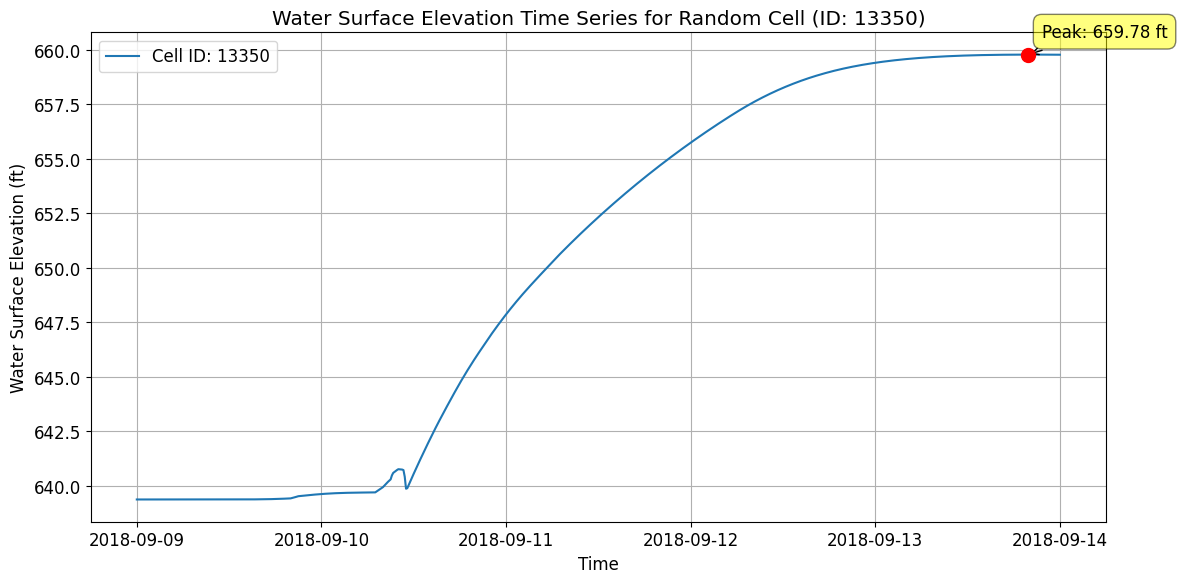

Statistics for Cell ID 13350:
Minimum WSEL: 639.36 ft
Maximum WSEL: 659.78 ft
Mean WSEL: 650.29 ft
Time of peak: 2018-09-13T19:50:00.000000000


In [106]:
# Plot WSE Time Series Data (Random Cell ID) 
import matplotlib.pyplot as plt

if generate_plots:
    import numpy as np
    import random

    # Extract Water Surface data
    water_surface = cells_timeseries_xr[mesh_areas[0]]['Water Surface']

    # Get the time values
    time_values = water_surface.coords['time'].values

    # Pick a random cell_id
    random_cell_id = random.choice(water_surface.coords['cell_id'].values)

    # Extract the water surface elevation time series for the random cell
    wsel_timeseries = water_surface.sel(cell_id=random_cell_id)

    # Find the peak value and its index
    peak_value = wsel_timeseries.max().item()
    peak_index = wsel_timeseries.argmax().item()

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(time_values, wsel_timeseries, label=f'Cell ID: {random_cell_id}')
    plt.scatter(time_values[peak_index], peak_value, color='red', s=100, zorder=5)
    plt.annotate(f'Peak: {peak_value:.2f} ft', 
                (time_values[peak_index], peak_value),
                xytext=(10, 10), textcoords='offset points',
                ha='left', va='bottom',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    plt.title(f'Water Surface Elevation Time Series for Random Cell (ID: {random_cell_id})')
    plt.xlabel('Time')
    plt.ylabel('Water Surface Elevation (ft)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Log the plotting action
    logging.info(f"Plotted water surface elevation time series for random cell ID: {random_cell_id}")

    # Display the plot
    plt.show()

    # Print some statistics
    print(f"Statistics for Cell ID {random_cell_id}:")
    print(f"Minimum WSEL: {wsel_timeseries.min().item():.2f} ft")
    print(f"Maximum WSEL: {peak_value:.2f} ft")
    print(f"Mean WSEL: {wsel_timeseries.mean().item():.2f} ft")
    print(f"Time of peak: {time_values[peak_index]}")

In [107]:
# Get mesh faces timeseries output as xarray
faces_timeseries_xr = HdfResultsMesh.get_mesh_faces_timeseries(plan_hdf_path, mesh_areas[0])

2025-12-16 21:03:41 - ras_commander.hdf.HdfResultsMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:41 - ras_commander.hdf.HdfResultsMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:41 - ras_commander.hdf.HdfResultsMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:41 - ras_commander.hdf.HdfResultsMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:42 - ras_commander.hdf.HdfResultsMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:42 - ras_commander.hdf.HdfResultsMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


In [108]:
faces_timeseries_xr

<xarray.Dataset> Size: 217MB
Dimensions:        (time: 720, face_id: 37594)
Coordinates:
  * time           (time) datetime64[ns] 6kB 2018-09-09T00:10:00 ... 2018-09-14
  * face_id        (face_id) int64 301kB 0 1 2 3 4 ... 37590 37591 37592 37593
Data variables:
    face_velocity  (time, face_id) float32 108MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    face_flow      (time, face_id) float32 108MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    units:      ft/s
    mesh_name:  BaldEagleCr
    variable:   Face Velocity

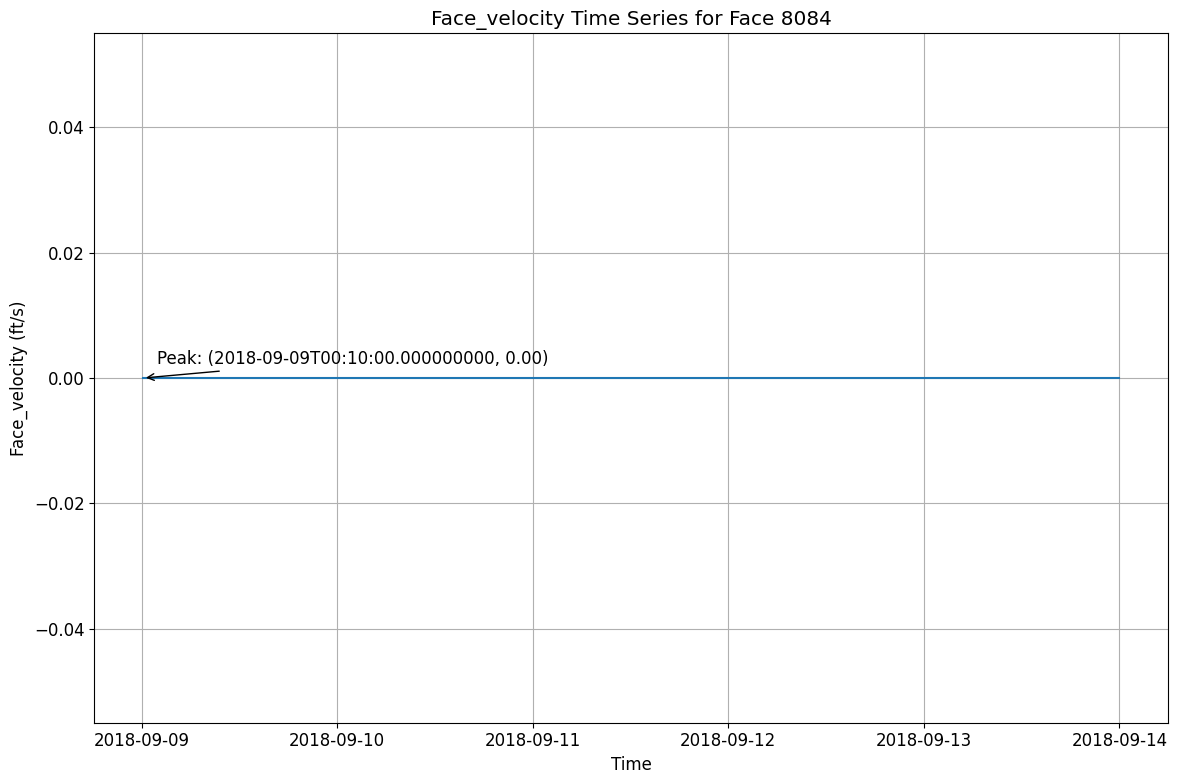

2025-12-16 21:03:43 - root - INFO - Terrain TIFF not found at C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\Terrain\Terrain50.baldeagledem.tif, skipping terrain overlay


C:\Users\billk_clb\AppData\Local\Temp\ipykernel_27044\423459082.py:142: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


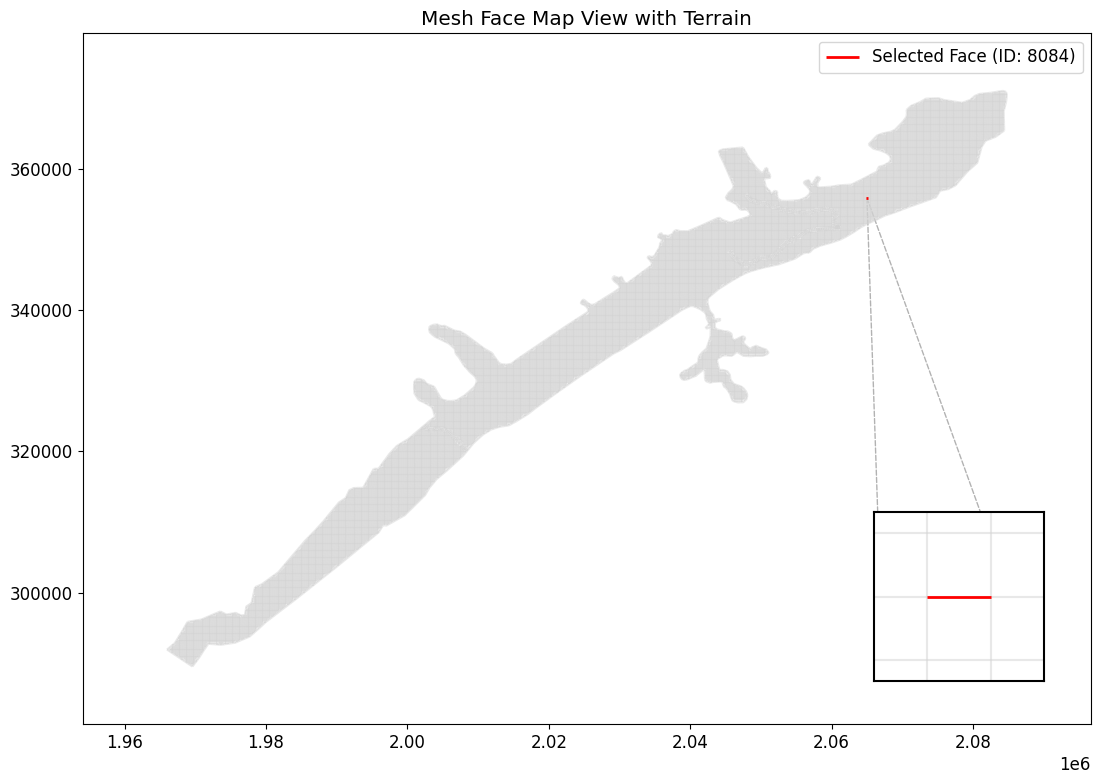

2025-12-16 21:03:45 - root - INFO - Plotted mesh face time series and map view for random face ID: 8084 with terrain


Random Face: 8084
Peak Value: 0.00 ft/s at 2018-09-09T00:10:00.000000000


In [109]:
# Plot Random Face Results and Label Peak, Plus Map View

if generate_maps:

    # Select a random valid face ID number
    random_face = np.random.randint(0, faces_timeseries_xr.sizes['face_id'])

    # Extract time series data for the selected face
    variable = 'face_velocity'  # We could also use 'face_flow'
    face_data = faces_timeseries_xr[variable].sel(face_id=random_face)

    # Find peak value and its corresponding time
    peak_value = face_data.max().item()
    peak_time = face_data.idxmax().values

    # Plot time series
    plt.figure(figsize=(12, 8))
    plt.plot(faces_timeseries_xr.time, face_data)
    plt.title(f'{variable.capitalize()} Time Series for Face {random_face}')
    plt.xlabel('Time')
    plt.ylabel(f'{variable.capitalize()} ({faces_timeseries_xr.attrs["units"]})')
    plt.grid(True)

    # Annotate the peak point
    plt.annotate(f'Peak: ({peak_time}, {peak_value:.2f})', 
                (peak_time, peak_value),
                xytext=(10, 10), textcoords='offset points',
                arrowprops=dict(arrowstyle="->"))

    # Check for negative values and label the minimum if present
    min_value = face_data.min().item()
    if min_value < 0:
        min_time = face_data.idxmin().values
        plt.annotate(f'Min: ({min_time}, {min_value:.2f})', 
                    (min_time, min_value),
                    xytext=(10, -10), textcoords='offset points',
                    arrowprops=dict(arrowstyle="->"))

    plt.tight_layout()
    plt.show()

    # Create map view plot
    fig, ax = plt.subplots(figsize=(12, 8))


    # Calculate mesh faces extents with 10% buffer
    faces_bounds = mesh_cell_faces_gdf.total_bounds
    x_min, y_min, x_max, y_max = faces_bounds
    buffer_x = (x_max - x_min) * 0.1
    buffer_y = (y_max - y_min) * 0.1
    plot_xlim = [x_min - buffer_x, x_max + buffer_x]
    plot_ylim = [y_min - buffer_y, y_max + buffer_y]

    # Set plot limits before adding terrain
    ax.set_xlim(plot_xlim)
    ax.set_ylim(plot_ylim)

    # Add the terrain TIFF to the map if available
    tiff_path = Path.cwd() / 'example_projects' / 'BaldEagleCrkMulti2D' / 'Terrain' / 'Terrain50.baldeagledem.tif'
    if tiff_path.exists():
        with rasterio.open(tiff_path) as src:
            show(src, ax=ax, cmap='terrain', alpha=0.5)
    else:
        logging.info(f'Terrain TIFF not found at {tiff_path}, skipping terrain overlay')
        
    # Reset the limits after terrain plot
    ax.set_xlim(plot_xlim)
    ax.set_ylim(plot_ylim)

    # Plot all faces in gray
    mesh_cell_faces_gdf.plot(ax=ax, color='lightgray', alpha=0.5, zorder=2)

    # Get the selected face geometry
    selected_face = mesh_cell_faces_gdf[mesh_cell_faces_gdf['face_id'] == random_face]

    # Highlight the selected face in red
    selected_face.plot(
        ax=ax, 
        color='red',
        linewidth=2,
        label=f'Selected Face (ID: {random_face})',
        zorder=3
    )

    # Get bounds of selected face for zoomed inset
    bounds = selected_face.geometry.bounds.iloc[0]
    x_center = (bounds.iloc[0] + bounds.iloc[2]) / 2
    y_center = (bounds.iloc[1] + bounds.iloc[3]) / 2
    buffer = max(bounds.iloc[2] - bounds.iloc[0], bounds.iloc[3] - bounds.iloc[1]) * 2

    # Create zoomed inset with a larger size, inside the map frame
    axins = inset_axes(ax, width="70%", height="70%", loc='lower right',
                    bbox_to_anchor=(0.65, 0.05, 0.35, 0.35),
                    bbox_transform=ax.transAxes)

    # Plot terrain and faces in inset (if available)
    if tiff_path.exists():
        with rasterio.open(tiff_path) as src:
            show(src, ax=axins, cmap='terrain', alpha=0.5)
        
    # Plot zoomed view in inset
    mesh_cell_faces_gdf.plot(ax=axins, color='lightgray', alpha=0.5, zorder=2)
    selected_face.plot(ax=axins, color='red', linewidth=2, zorder=3)

    # Set inset limits with slightly more context
    axins.set_xlim(x_center - buffer/1.5, x_center + buffer/1.5)
    axins.set_ylim(y_center - buffer/1.5, y_center + buffer/1.5)

    # Remove inset ticks for cleaner look
    axins.set_xticks([])
    axins.set_yticks([])

    # Add a border to the inset
    for spine in axins.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)

    # Create connection lines between main plot and inset
    # Get the selected face centroid for connection point
    centroid = selected_face.geometry.centroid.iloc[0]
    con1 = ConnectionPatch(
        xyA=(centroid.x, centroid.y), coordsA=ax.transData,
        xyB=(0.02, 0.98), coordsB=axins.transAxes,
        arrowstyle="-", linestyle="--", color="gray", alpha=0.6
    )
    con2 = ConnectionPatch(
        xyA=(centroid.x, centroid.y), coordsA=ax.transData,
        xyB=(0.98, 0.02), coordsB=axins.transAxes,
        arrowstyle="-", linestyle="--", color="gray", alpha=0.6
    )

    ax.add_artist(con1)
    ax.add_artist(con2)

    # Add title and legend to main plot
    ax.set_title('Mesh Face Map View with Terrain')
    ax.legend()

    # Ensure equal aspect ratio while maintaining our desired extents
    ax.set_aspect('equal', adjustable='box')

    plt.tight_layout()
    plt.show()

    # Print summary information
    print(f"Random Face: {random_face}")
    print(f"Peak Value: {peak_value:.2f} {faces_timeseries_xr.attrs['units']} at {peak_time}")
    if min_value < 0:
        print(f"Minimum Value: {min_value:.2f} {faces_timeseries_xr.attrs['units']} at {min_time}")

    # Log the plotting action
    logging.info(f"Plotted mesh face time series and map view for random face ID: {random_face} with terrain")

In [110]:
# Get meteorology precipitation attributes
meteo_precip_attrs = HdfPlan.get_plan_met_precip(plan_hdf_path)


2025-12-16 21:03:45 - ras_commander.hdf.HdfPlan - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:45 - ras_commander.hdf.HdfPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


In [111]:
meteo_precip_attrs

{'DSS Filename': '.\\Precipitation\\precip.2018.09.dss',
 'DSS Pathname': '/SHG/MARFC/PRECIP/01SEP2018:0200/01SEP2018:0300/NEXRAD/',
 'Data Type': 'per-cum',
 'Interpolation Method': '',
 'Mode': 'Gridded',
 'Projection': 'PROJCS["USA_Contiguous_Albers_Equal_Area_Conic_USGS_version",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]',
 'Raster Cellsize': np.float64(2000.0),
 'Raster Cols': np.int32(515),
 'Raster Left': np.float64(1096000.0),
 'Raster Rows': np.int32(522),
 'Raster Top': np.float64(2560000.0),
 'So

In [112]:
# Get results unsteady attributes
results_unsteady_attrs = HdfResultsPlan.get_unsteady_info(plan_hdf_path)


2025-12-16 21:03:45 - ras_commander.hdf.HdfResultsPlan - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:45 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


In [113]:
results_unsteady_attrs

,Plan Title,Program Name,Program Version,Project File Name,Project Title,Short ID,Simulation Time Window,Type of Run
0,Gridded Precip - Infiltration,HEC-RAS - River Analysis System,HEC-RAS 6.6 September 2024,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,Bald Eagle Creek Example Dam Break Study,Grid Precip Infiltration,08Sep2018 2400 to 13Sep2018 2400,Unsteady Flow Analysis


In [114]:
# Get results unsteady summary attributes
results_unsteady_summary_attrs = HdfResultsPlan.get_unsteady_summary(plan_hdf_path)


2025-12-16 21:03:45 - ras_commander.hdf.HdfResultsPlan - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:45 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


In [115]:
results_unsteady_summary_attrs

,Computation Time DSS,Computation Time Total,Maximum WSEL Error,Maximum number of cores,Run Time Window,Solution,Time Solution Went Unstable,Time Stamp Solution Went Unstable
0,00:00:00,00:04:39,0.0,2,16DEC2025 20:58:42 to 16DEC2025 21:03:20,Unsteady Finished Successfully,NaN,Not Applicable


In [116]:
# Get results volume accounting attributes
volume_accounting_attrs = HdfResultsPlan.get_volume_accounting(plan_hdf_path)

2025-12-16 21:03:45 - ras_commander.hdf.HdfResultsPlan - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


2025-12-16 21:03:45 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_11\BaldEagleDamBrk.p06.hdf


In [117]:
volume_accounting_attrs

,Error,Error Percent,Precipitation Excess (acre feet),Precipitation Excess (inches),Total Boundary Flux of Water In,Total Boundary Flux of Water Out,Vol Accounting in,Volume Ending,Volume Starting
0,0.469724,0.000332,3756.872803,1.707615,141685.0,17240.263672,Acre Feet,124445.203125,0.0


-----

In [118]:
# Extract Compute Messages as String
print("Extracting Compute Messages")

import h5py
import numpy as np



def extract_string_from_hdf(results_hdf_filename: str, hdf_path: str) -> str:
    """
    Extract string from HDF object at a given path

    Parameters
    ----------
    results_hdf_filename : str
        Name of the HDF file
    hdf_path : str
        Path of the object in the HDF file

    Returns
    -------
    str
        Extracted string from the specified HDF object
    """
    with h5py.File(results_hdf_filename, 'r') as hdf_file:
        try:
            hdf_object = hdf_file[hdf_path]
            if isinstance(hdf_object, h5py.Group):
                return f"Group: {hdf_path}\nContents: {list(hdf_object.keys())}"
            elif isinstance(hdf_object, h5py.Dataset):
                data = hdf_object[()]
                if isinstance(data, bytes):
                    return data.decode('utf-8')
                elif isinstance(data, np.ndarray) and data.dtype.kind == 'S':
                    return [v.decode('utf-8') for v in data]
                else:
                    return str(data)
            else:
                return f"Unsupported object type: {type(hdf_object)}"
        except KeyError:
            return f"Path not found: {hdf_path}"



try:
    results_summary_string = extract_string_from_hdf(plan_hdf_path, '/Results/Summary/Compute Messages (text)')
    print("Compute Messages:")
    
    # Parse and print the compute messages in a more visually friendly way
    messages = results_summary_string[0].split('\r\n')
    
    for message in messages:
        if message.strip():  # Skip empty lines
            if ':' in message:
                key, value = message.split(':', 1)
                print(f"{key.strip():40} : {value.strip()}")
            else:
                print(f"\n{message.strip()}")
    
    # Print computation summary in a table format
    print("\nComputation Summary:")
    print("-" * 50)
    print(f"{'Computation Task':<30} {'Time':<20}")
    print("-" * 50)
    for line in messages:
        if 'Computation Task' in line:
            task, time = line.split('\t')
            print(f"{task:<30} {time:<20}")
    
    print("\nComputation Speed:")
    print("-" * 50)
    print(f"{'Task':<30} {'Simulation/Runtime':<20}")
    print("-" * 50)
    for line in messages:
        if 'Computation Speed' in line:
            task, speed = line.split('\t')
            print(f"{task:<30} {speed:<20}")

except Exception as e:
    print(f"Error extracting compute messages: {str(e)}")
    print("\nNote: If 'Results/Summary Output' is not in the file structure, it might indicate that the simulation didn't complete successfully or the results weren't saved properly.")

 



Extracting Compute Messages
Compute Messages:
Plan                                     : 'Gridded Precip - Infiltration' (BaldEagleDamBrk.p06)
Simulation started at                    : 16Dec2025 08:58:27 PM

Writing Plan GIS Data...

Completed Writing Plan GIS Data

Writing Geometry...
Computing 2D Flow Area 'BaldEagleCr' tables : Property tables do not exist.

2D Flow Area 'BaldEagleCr' tables complete 9.11 sec

Completed Writing Geometry

Writing Event Conditions ...

Processing Precipitation data...

(assumes geometry data is geo-referenced)

Finished Processing Precipitation data (1.558s)

Completed Writing Event Condition Data

Geometric Preprocessor HEC-RAS 6.6 September 2024

Finished Processing Geometry

Performing Unsteady Flow Simulation  HEC-RAS 6.6 September 2024
Unsteady Input Summary                   : 

2D Unsteady Diffusion Wave Equation Set (fastest)
2D number of Solver Cores                : 2

Maximum adaptive timestep = 40.0    Minimum adaptive timestep = 20.0

In

## Exploring HDF Datasets with HdfBase.get_dataset_info
This allows users to find HDF information that is not included in the ras-commander library.  Find the path in HDFView and set the group_path below to explore the HDF datasets and attributes.  Then, use the output to write your own function to extract the data.  

#### Get HDF Paths with Properties (For Exploring HDF Files)
HdfBase.get_dataset_info(plan_number, group_path="/")

## Common 2D Mesh Extraction Patterns### Pattern 1: Extract Maximum Inundation```python# Get maximum depth at each cell over entire simulationmax_depth = HdfResultsMesh.get_max_depth(plan_number, flow_area_name, ras_object=ras)# Typical use: Flood mapping, regulatory analysis```### Pattern 2: Time Series at Point of Interest```python# Find cell nearest to point of interestpoi = (x_coord, y_coord)  # Coordinates of interestnearest_cell_idx = find_nearest_cell(mesh_geometry, poi)# Extract full time series at that celldepth_ts = depth_2d[:, nearest_cell_idx]  # All time steps, single cell# Plot time seriesplt.plot(time_stamps, depth_ts)plt.title('Depth Hydrograph at POI')```### Pattern 3: Animate Inundation Progression```python# Create animation of depth over timefrom matplotlib.animation import FuncAnimationfig, ax = plt.subplots()for time_idx in range(num_time_steps):    depth_snapshot = depth_2d[time_idx, :]    # Plot depth on mesh    # Update animation frame```### Pattern 4: Identify High-Velocity Areas```python# Find cells with velocity > threshold (erosion concern)erosion_threshold = 6.0  # ft/shigh_velocity_cells = velocity_2d > erosion_threshold# Export for mitigation planninghigh_vel_locations = mesh_geometry[high_velocity_cells]```### Pattern 5: Volume Calculation```python# Calculate inundated volume at each time stepcell_areas = mesh_geometry['cell_area']volume = np.sum(depth_2d * cell_areas, axis=1)  # Sum over cells for each time# Plot volume vs timeplt.plot(time_stamps, volume)plt.ylabel('Inundated Volume (cu ft)')```## Cross-References- **1D Results**: See `400_1d_hdf_data_extraction.ipynb` for cross section data- **Face Data**: See `412_2d_detail_face_data_extraction.ipynb` for cell face velocities/flow- **Pipes/Pumps**: See `411_2d_hdf_pipes_and_pumps.ipynb` for hydraulic structures in 2D areas- **Breach**: See `420_breach_results_extraction.ipynb` for dam breach progression

For HDF datasets that are not supported by the RAS-Commadner library, provide the dataset path to HdfBase.get_dataset_info and provide the output to an LLM along with a relevent HDF* class(es) to generate new functions that extend the library's coverage.   